# Project 3 - Recommender Systems

Gorkem Camli (105709280)

#### Library imports

In [1]:
import pandas as pd
import numpy as np
import random 
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from surprise.model_selection.validation import cross_validate
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from surprise import Reader, Dataset
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
rand_seed = 42
np.random.seed(rand_seed)
random.seed(rand_seed)

## Dataset

#### Data Exploration

In [3]:
folder_name = 'Synthetic_Movie_Lens/'
ratings_raw = pd.read_csv(folder_name+'ratings.csv', index_col=0)
movies = pd.read_csv(folder_name+'movies.csv')

In [4]:
print('Ratings Raws length: ',len(ratings_raw))
print('Data preview:')
ratings_raw.head(5)

Ratings Raws length:  100836
Data preview:


,userId,movieId,rating,timestamp
0,496,112852,3.0,1415520462
1,391,1947,4.0,1030945141
2,387,1562,1.5,1095041022
3,474,2716,4.5,1053020930
4,483,88125,4.5,1311337237


In [5]:
ratings_mat_df = ratings_raw.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
#display(ratings_mat_df)
print(f'Number of users: {ratings_mat_df.shape[0]}')
print(f'Number of movies: {ratings_mat_df.shape[1]}')

Number of users: 610
Number of movies: 9724


### Question 1


#### Question 1.A

Compute the sparsity of the movie rating dataset:

$$ \text{Sparsity} = \frac{\text{Total number of available ratings}} {\text{Total number of possible ratings}}$$


In [6]:
total_ratings = sum(ratings_mat_df.astype(bool).sum(axis=0))
total_possible_ratings = ratings_mat_df.shape[0]*ratings_mat_df.shape[1]
sparsity = total_ratings/total_possible_ratings

print(f'Total number of users: {ratings_mat_df.shape[0]}' )
print(f'Total number of movies: {ratings_mat_df.shape[1]}' )
print(f'Total number of available ratings: {total_ratings}' )
print(f'Total number of possible ratings = number of movies x number of users = {total_possible_ratings}' )
print(f'\n\nThe sparsity of the movie rating dataset is: {sparsity}' )

Total number of users: 610
Total number of movies: 9724
Total number of available ratings: 100836
Total number of possible ratings = number of movies x number of users = 5931640


The sparsity of the movie rating dataset is: 0.016999683055613623


#### Question 1.B

Plot a histogram showing the frequency of the rating values: Bin the raw rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R that fall within each bin and use this count as the height of the vertical axis for that particular bin. Comment on the shape of the histogram.

In [7]:
# Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).
print('Ratings Scale:')
print(sorted(ratings_raw.rating.unique()))

Ratings Scale:
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Text(0, 0.5, 'Number of Ratings (Frequency)')

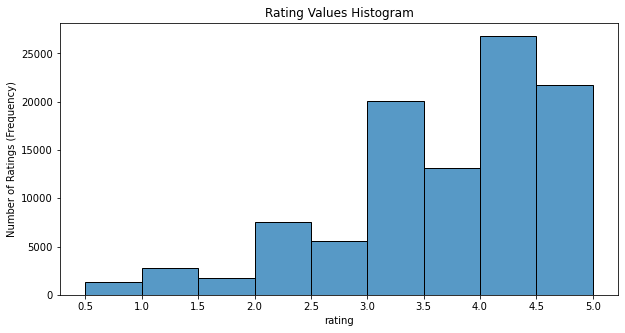

In [8]:
bins_range = sorted(ratings_raw.rating.unique())
plt.figure(figsize=(10,5))
g = sns.histplot(data=ratings_raw, x="rating", bins=bins_range)
#g.set(xticklabels=bins_range)
plt.xticks(bins_range)
plt.title('Rating Values Histogram')
plt.ylabel('Number of Ratings (Frequency)')

The ratings are within the 0.5 to 5.0 range. Users who gave ratings tends to give higher rating scores since the trend of the histogram is towards the higher ratings. Around 81% of the ratings are 3 and above and 21.5% is 4.5 and above. One possible interpretation is that users may tend to give ratings to the movies they like or they liked the movies they watched.


In [9]:
print('Ratings Count: \n',ratings_raw.rating.value_counts(sort=True))
print('Ratings Count normalized: \n',ratings_raw.rating.value_counts(sort=True, normalize=True))

Ratings Count: 
 4.0    26816
3.0    20046
5.0    13211
3.5    13136
4.5     8553
2.0     7551
2.5     5551
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64
Ratings Count normalized: 
 4.0    0.265937
3.0    0.198798
5.0    0.131015
3.5    0.130271
4.5    0.084821
2.0    0.074884
2.5    0.055050
1.0    0.027877
1.5    0.017762
0.5    0.013586
Name: rating, dtype: float64


#### Question 1.C

Plot the distribution of the number of ratings received among movies: The X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend is expected.

In [10]:
rating_count_per_movie = pd.DataFrame(ratings_raw.groupby(by='movieId').rating.count().sort_values(ascending=False))
rating_count_per_movie.reset_index(inplace=True)
print('Top 10 movies with most ratings')
rating_count_per_movie.rename(columns={'rating':'rating_count'}, inplace=True)
display(rating_count_per_movie.head(10).T)

Top 10 movies with most ratings


,0,1,2,3,4,5,6,7,8,9
movieId,356,318,296,593,2571,260,480,110,589,527
rating_count,329,317,307,279,278,251,238,237,224,220


Text(0, 0.5, 'Number of Ratings')

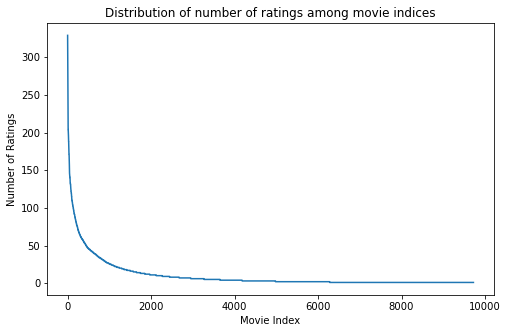

In [11]:
plt.figure(figsize=(8,5))
plt.plot(rating_count_per_movie.rating_count.values)
plt.title('Distribution of number of ratings among movie indices')
plt.xlabel('Movie Index')
plt.ylabel('Number of Ratings')

In [12]:
rating_count_per_movie.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,9724.0,42245.024373,52191.137320,1.0,3245.5,7300.0,76739.25,193609.0
rating_count,9724.0,10.369807,22.401005,1.0,1.0,3.0,9.00,329.0


In [13]:
print('Rating Count Normalized Value Counts:')
rating_count_per_movie.rating_count.value_counts(normalize=True)

Rating Count Normalized Value Counts:


1      0.354381
2      0.133484
3      0.082271
4      0.054504
5      0.039284
         ...   
203    0.000103
211    0.000103
251    0.000103
215    0.000103
307    0.000103
Name: rating_count, Length: 177, dtype: float64

As expected we observe a monotonically decreasing trend. Majority of the movies rated very few or 1 times only. This shows that there a few popular movies that are rated among many users and majority of the movies rated by few users. This points out that there is sparsity in the data.

#### Question 1.D

Plot the distribution of ratings among users: The X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user has rated. The requirement of the plot is similar to that in Question C. 

In [14]:
rating_count_per_user = pd.DataFrame(ratings_raw.groupby(by='userId').rating.count().sort_values(ascending=False))
rating_count_per_user.reset_index(inplace=True)
print('Top 10 users with most ratings')
rating_count_per_user.rename(columns={'rating':'rating_count'}, inplace=True)
rating_count_per_user.head(10).T

Top 10 users with most ratings


,0,1,2,3,4,5,6,7,8,9
userId,414,599,474,448,274,610,68,380,606,288
rating_count,2698,2478,2108,1864,1346,1302,1260,1218,1115,1055


Text(0, 0.5, 'Number of Ratings')

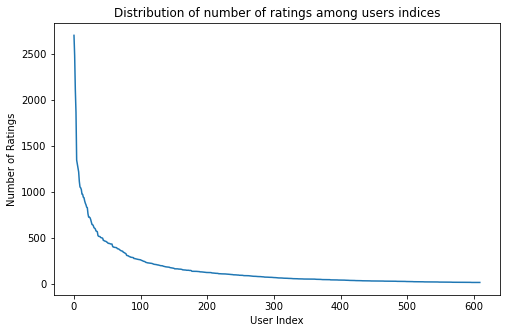

In [15]:
plt.figure(figsize=(8,5))
plt.plot(rating_count_per_user.rating_count.values)
plt.title('Distribution of number of ratings among users indices')
plt.xlabel('User Index')
plt.ylabel('Number of Ratings')

In [16]:
rating_count_per_user.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,610.0,305.500000,176.236111,1.0,153.25,305.5,457.75,610.0
rating_count,610.0,165.304918,269.480584,20.0,35.00,70.5,168.00,2698.0


In [17]:
print('Rating Count Normalized Value Counts:')
rating_count_per_user.rating_count.value_counts(normalize=True).sort_index()

Rating Count Normalized Value Counts:


20      0.022951
21      0.024590
22      0.022951
23      0.021311
24      0.011475
          ...   
1346    0.001639
1864    0.001639
2108    0.001639
2478    0.001639
2698    0.001639
Name: rating_count, Length: 261, dtype: float64

In [18]:
print('Rating Count Normalized Value Counts after cumsum from lines 45-51:')
rating_count_per_user.rating_count.value_counts(normalize=True).sort_index().cumsum()[45:51]

Rating Count Normalized Value Counts after cumsum from lines 45-51:


66    0.483607
67    0.486885
68    0.488525
69    0.496721
70    0.500000
71    0.501639
Name: rating_count, dtype: float64

Again we see a decreasing trend with a tailed curve. There are some users who did a lot of ratings but majority seems to rate low number of movies. The minimum number of ratings among the users is 20. Half of the users rated 70 or less movies out of 9724 movies, which again shows that there is an uneven distribution and sparsity in the ratings given by users.

#### Question 1.E

Discuss the salient features of the distributions from Questions C,D and their implications for the recommendation process.

In 1.C, the number of ratings given to movies has a monotonically decreasing trend with a long tail on the right. This means majority of the movies get very low number of ratings where few of the movies get majority of the ratings. Around 35.4% movies get only 1 rating. Similarly, in 1.D, the number of ratings given by users has a monotonically decreasing trend with a long tail as well. This means majority of the users gave few ratings, and there are few users with very high number of ratings. Half of the users gave at least 20 and at most 70 movie ratings. Given that we have 610 users and 9724 movies, the ratings matrix R is a sparse matrix. The sparsity we calculate in Q1.A with 0.0169 confirms this. Having a sparse matrix makes recommendation systems job harder, as there are few links between users and movies. This means if there is a low number rating for a specific movie, it will be harder to rate that movie based on similar users, or if the user has a low number of rating it will be hard to learn about what users might like or not. Given the sparsity of matrix finding the similarities between users or movies will be challenging because we will have to work on small number of ratings, given that majority of the values are 0. 
This might cause problems such as overfitting or false predictions on the ratings. As described in the page 6 of the specification part, we might need to regularize our models to avoid overfitting. 

#### Question 1.F

Compute the variance of the rating values received by each movie: Bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the resulting histogram.

In [19]:
rating_count_per_movie_var = pd.DataFrame(ratings_raw.groupby(by='movieId').agg(max_rating=('rating', 'max'), min_rating=('rating', 'min'), rating_variance=('rating', 'var'), rating_count=('rating', 'count'), rating_mean=('rating', 'mean'))).reset_index()
print('Movie based stats table preview: ')
rating_count_per_movie_var.head(10).T

Movie based stats table preview: 


,0,1,2,3,4,5,6,7,8,9
movieId,1.00000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000,10.000000
max_rating,5.00000,5.000000,5.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000,5.000000
min_rating,0.50000,0.500000,0.500000,1.000000,0.500000,1.000000,1.000000,1.000000,1.500,0.500000
rating_variance,0.69699,0.777419,1.112651,0.726190,0.822917,0.670841,0.955625,1.267857,0.950,0.738535
rating_count,215.00000,110.000000,52.000000,7.000000,49.000000,102.000000,54.000000,8.000000,16.000,132.000000
rating_mean,3.92093,3.431818,3.259615,2.357143,3.071429,3.950980,3.185185,2.875000,3.125,3.496212


In [20]:
print('Description of Movie based stats table: ')
rating_count_per_movie_var.describe()

Description of Movie based stats table: 


,movieId,max_rating,min_rating,rating_variance,rating_count,rating_mean
count,9724.000000,9724.000000,9724.000000,6278.000000,9724.000000,9724.000000
mean,42245.024373,3.912999,2.416495,0.857169,10.369807,3.262448
std,52191.137320,1.056532,1.241600,0.795839,22.401005,0.869874
min,1.000000,0.500000,0.500000,0.000000,1.000000,0.500000
25%,3245.500000,3.500000,1.500000,0.395833,1.000000,2.800000
50%,7300.000000,4.000000,2.500000,0.702111,3.000000,3.416667
75%,76739.250000,5.000000,3.500000,1.105310,9.000000,3.911765
max,193609.000000,5.000000,5.000000,10.125000,329.000000,5.000000


Text(0.5, 1.0, 'Histogram of Rating Values (Unbiased) Variance per movie')

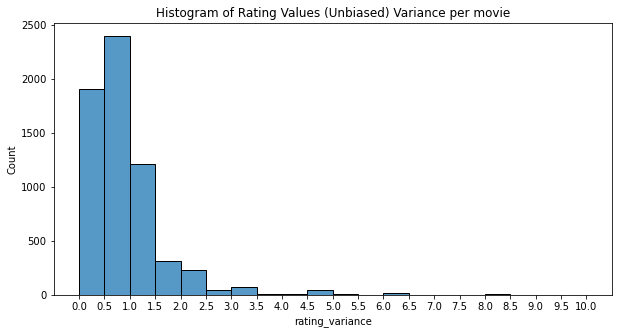

In [21]:
bin_vals = np.arange(rating_count_per_movie_var.rating_variance.min(), rating_count_per_movie_var.rating_variance.max(),0.5)
#print(bin_vals)
plt.figure(figsize=(10,5))
sns.histplot(data=rating_count_per_movie_var, x="rating_variance", bins=bin_vals)
plt.xticks(bin_vals)
plt.title('Histogram of Rating Values (Unbiased) Variance per movie')

In [22]:
var_lt_1 = round(rating_count_per_movie_var[rating_count_per_movie_var.rating_variance<=1].shape[0]*100/rating_count_per_movie_var.shape[0],2)
print(f'Movies percentage that has variance less than or equal 1: {var_lt_1}%')
var_lt_1_5 = round(rating_count_per_movie_var[rating_count_per_movie_var.rating_variance<=1.5].shape[0]*100/rating_count_per_movie_var.shape[0],2)
print(f'Movies percentage that has variance less than or equal 1.5: {var_lt_1_5}%')

Movies percentage that has variance less than or equal 1: 44.94%
Movies percentage that has variance less than or equal 1.5: 56.78%


I used unbiased variance to calculate variance values. From the histogram, we can see that majority of the movies variance are in the range of 0 to 1.5. almost 44.94% of the movies has a variance <= 1 and 56.78% movies has a variance of <=1.5. This means that most of the movies min and max rating range is close to each other, and the ratings given by users are similar and could be relied for the recommendations. There are few movies where the variance range  is very high and even extreme cases where variance is more than 5. From our observation those movies are the ones that received few ratings and the ratings are very different. For example for the movieId 2068, there are 2 ratings: [5.0, 0.5] - variance is 10.125. For these few extreme cases and movies with high variances, we can commment that the ratings given by users are inconsistent and not very reliable.

## Neighborhood-based collaborative filtering

### Question 2

#### Question 2.A

Write down the formula for $μ_u$ in terms of $I_u$ and $r_{uk}$


 $$ \mu_u = \frac{\text{Sum of ratings given by user u}}{\text{Number of ratings given by user u}} $$
 
 
 $$  \mu_u = \frac{\sum_{k	\in I_u} r_{uk}}{|I_u|}    $$
 

$\mu_u$ represents the mean of the ratings given by user u. 

#### Question 2.B

In plain words, explain the meaning of \begin{equation} I_u ∩ I_v \end{equation}. Can \begin{equation} I_u ∩ I_v = ∅ \end{equation} ? (Hint: Rating matrix R is sparse)

\begin{equation} I_u ∩ I_v \end{equation} are the set of movies where both user u and user v rated. Because R matrix is sparse, it is very likely that for some user u and user v, they don't have any common movies they rated, hence the intersection of them is empty: \begin{equation} I_u ∩ I_v = ∅ \end{equation}. 

### Question 3

Understanding the Prediction function: Can you explain the reason behind mean-centering the raw ratings $(r_{vj} − μ_v)$ in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function.)

 Ratings can be subjective for every person, some people might be more prone to give higher scores and some prone to give lower scores. Therefore, score distribution of users also could be very different. We are not interested in the absolute rating for a movie from a user, because let's say an average rating for user A is 4 and he gave a movie rating 2.5 to movie X, thinks movie is bad, and user B has an average rating of 2. Then when we try to predict User B's rating, if we use absolute score, user B will think like user A liked the movie (user B's avg was 2) and become prone to like movie X. If both users have similar tastes, B should have dislike the movie as well. Similarly these things can happen when there are users who rate high or low all the time. This cause biases during the prediction of ratings.

To reduce subjectivity and bias, we should interpret the score given by users relatively rather than absolute rating, and standardize them. Otherwise we might end up biasing our predicted rating and misinterpreting the score given by other users. To standardize user ratings we do mean centering around each user. In this way, mean centering can reduce the user bias, and help us predict more accurate and unbiased rating scores.

### Question 4

Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).


I used KNNwithMeans model from surprise library to for the KNN collaborative filter because the prediction calculation made by KNNwithMeans was the one corresponding to Equation 3 in the project description pdf. The plots below shows that Average RMSE and MAE results accross 10-fold for each k from 2 to 100, with step sizes 2.

RMSE: Root Mean Square Error, takes the square root of average of the squared differences betweeen true ratings and predicted ratings. RMSE penalize more when the difference between true and predicted rating is higher (takes square of the error). Therefore, it is affected more by bad predictions and outliers.

MAE: Mean Average Error, is the average of absolute difference between true rating and predicted rating. Therefore, it is not biased towards big errors (bad predictions) as RMSE and it penalizes all predictions equally.

In [23]:
reader = Reader(rating_scale=(0.5, 5))
ratings_data = Dataset.load_from_df(ratings_raw[['userId', 'movieId', 'rating']], reader)

In [72]:
def evaluate_model(data, model_type, k_range, plot_dets, is_plot=True, print_update=False):
    avg_rmse, avg_mae = [], []
    cv_results_list = []
    for i, k in enumerate(k_range):
        if i % 10==0 and print_update:
            print(f'{i} / {len(k_range)} -- k: {k}')
        
        model = get_model(model_type=model_type, k=k)
        cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
        cv_results_list.append(cv_results)
        avg_rmse.append(np.mean(cv_results['test_rmse']))
        avg_mae.append(np.mean(cv_results['test_mae']))
        
    if is_plot: 
        plot_evaluation_metric(x= k_range, 
                               ys=[avg_rmse],
                               x_label=plot_dets['x_label'],
                               y_label='Average RMSE accross 10-fold CV',
                               title=plot_dets['title'], 
                               labels=['Average RMSE'])
        plot_evaluation_metric(x= k_range, 
                               ys=[avg_mae],
                               x_label=plot_dets['x_label'],
                               y_label='Avergae MAE accross 10-fold CV',
                               title=plot_dets['title'], 
                               labels=['Average MAE'])
        res_pdf = pd.DataFrame({'k': k_range, 'avg_rmse':avg_rmse, 'avg_mae':avg_mae, 'cv_results':cv_results_list })
        return res_pdf

def plot_evaluation_metric(x, ys, x_label, y_label, title, labels,  fig_size=(10,7)):
    colors = ['blue','green','orange','purple']
    plt.figure(figsize=fig_size)
    for i, y in enumerate(ys):
        plt.plot(x, y, label = labels[i], color=colors[i])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.show()
    
def get_model(model_type, k):
    model = None
    if model_type == 'KNN':
        model = KNNWithMeans(k=k, sim_options = {'name':'pearson', 'user_based':True}, verbose=0) 
    elif model_type == 'NMF':
        model = NMF(n_factors=k, random_state=rand_seed, verbose=0)
    elif model_type == 'MF':
        model = SVD(n_factors=k, biased=True, random_state=rand_seed, verbose=0)
    else: 
        raise 'Wrong trim type: select from popular, unpopular or high_variance'
        
    return model

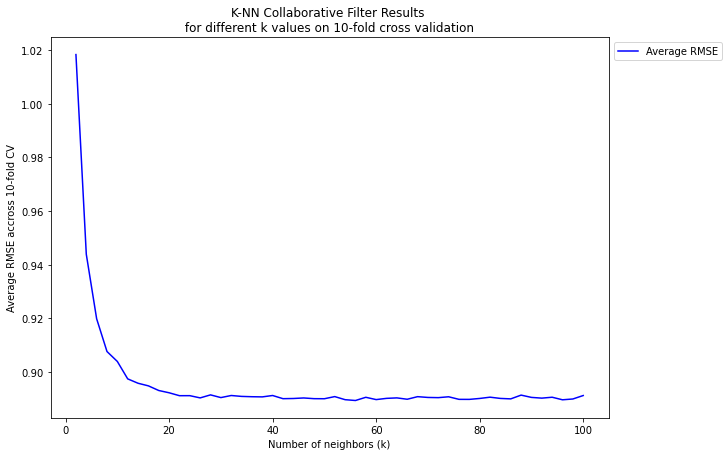

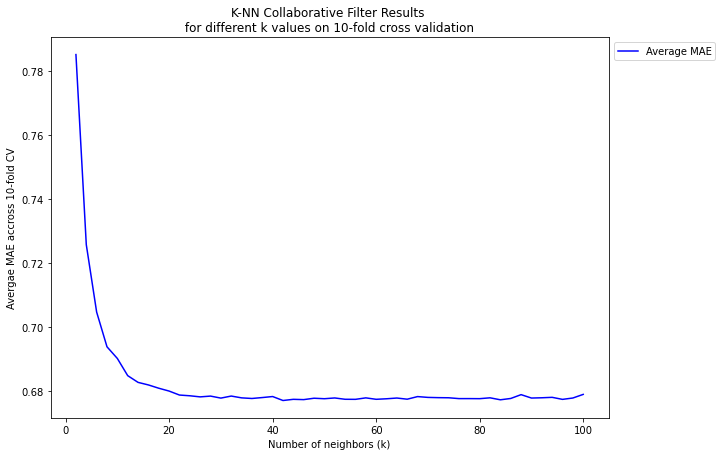

In [25]:
plot_dets_q4 = {
    'x_label': 'Number of neighbors (k)',
    'y_label': 'Average Test Error accross 10-fold CV',
    'title': 'K-NN Collaborative Filter Results \n for different k values on 10-fold cross validation '
}
k_range_q4 = list(range(2, 101, 2))
q4_exp_df = evaluate_model(data=ratings_data, model_type='KNN', k_range=k_range_q4, plot_dets=plot_dets_q4)

In [31]:
q4_exp_df.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
k,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30
avg_rmse,1.0184,0.943863,0.919774,0.907544,0.903836,0.897336,0.895703,0.894728,0.892995,0.892148,0.891058,0.891069,0.890236,0.891363,0.890353
avg_mae,0.785199,0.725791,0.704725,0.693875,0.690233,0.684864,0.682759,0.68196,0.680934,0.680044,0.678801,0.678574,0.678228,0.678474,0.677846
cv_results,"{'test_rmse': [1.0064455149967226, 1.031740256...","{'test_rmse': [0.9361455127443382, 0.936461550...","{'test_rmse': [0.9167145310841434, 0.912939917...","{'test_rmse': [0.8955187655975912, 0.896143192...","{'test_rmse': [0.9004002958024331, 0.906640460...","{'test_rmse': [0.8920181051105353, 0.904678838...","{'test_rmse': [0.8984940103116476, 0.884587799...","{'test_rmse': [0.8944573838012619, 0.894354533...","{'test_rmse': [0.8964935529488661, 0.891298673...","{'test_rmse': [0.8999086243769336, 0.887705797...","{'test_rmse': [0.8803154535306453, 0.903646226...","{'test_rmse': [0.8995998966443965, 0.891611505...","{'test_rmse': [0.8849716486009225, 0.897649236...","{'test_rmse': [0.8772238268582336, 0.891535332...","{'test_rmse': [0.8844422049951735, 0.891825697..."


From the above plot, we can observe that both RMSE and MAE curves start with high error values, follow a decreasing trend and plateus after certain k. As expected, RMSE Errors is higher than MAE. At first by increasing k values, we decrease the error a lot, probably because the neighbors we look at are not enough to do correct predictions, and as we increase k values, the model starts to perform better as it learns from more neighbors. However, after a moment increasing k doesn't change our results too much and the errors stabilizes. The reeason for that might be the new added neighbors, become less similar to the user, which causes the Pearson Correlation to be small and the new neighbors doesn't effect too much the rating prediction (Equation 3).       

### Question 5

Use the plot from question 4, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE.

In [32]:
q4_exp_df[['k','avg_rmse','avg_mae']]

,k,avg_rmse,avg_mae
0,2,1.018401,0.785199
1,4,0.943863,0.725791
2,6,0.919774,0.704725
3,8,0.907544,0.693875
4,10,0.903836,0.690233
5,12,0.897336,0.684864
6,14,0.895703,0.682759
7,16,0.894728,0.681960
8,18,0.892995,0.680934
9,20,0.892148,0.680044


After checking the plot in Question 4, both RMSE and MAE curves starts to plateau somewhere close to k=20. When we check above table to further investigate, we can see 2 points where the errors starts to stabilizes after reaching k=12, both RMSE and MAE results loses its momentum to decrease, and changes starts to happen in 3rd decimal points. However, if we look further another decrease happens in k=22, then the error starts to change mostly around 4th decimal point, and stays in a steady state until the end of the experiment.

Errors when k=22
- RMSE = 0.891058
- MAE = 0.678801

I chose minimum k as k=22 for KNN.  

### Question 6

For EACH of the 3 subsets in the test set, design:

A k-NN collaborative filter to predict the ratings of the movies in the test subset (i.e Popular, Unpopular or High-Variance) and evaluate each of the three models’ performance using 10-fold cross validation:
- Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.
- Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. For each of the plots, also report the area under the curve (AUC) value.

I first created 3 movie id lists to be used in the questions where we create custom test set: popular movies, unpopular movies and high variance movies following the rules given for each trimming type.

In [33]:
popular_movies = rating_count_per_movie_var[rating_count_per_movie_var.rating_count > 2].movieId.values
unpopular_movies = rating_count_per_movie_var[rating_count_per_movie_var.rating_count <= 2].movieId.values
high_var_movies = rating_count_per_movie_var[(rating_count_per_movie_var.rating_count >= 5) & (rating_count_per_movie_var.rating_variance >= 2)].movieId.values

print(f'Number of popular movies: {len(popular_movies)}')
print(f'Number of unpopular movies: {len(unpopular_movies)}')
print(f'Number of high variance movies: {len(high_var_movies)}')

Number of popular movies: 4980
Number of unpopular movies: 4744
Number of high variance movies: 87


#### Methods

In [34]:
def clean_based_on_trim_type(data, trim_type):
    trimmed_data = None
    if trim_type == 'popular':
        trimmed_data = trim_popular(data)
    elif trim_type == 'unpopular':
        trimmed_data = trim_unpopular(data)
    elif trim_type == 'high_variance':
        trimmed_data = trim_high_variance(data)
    else: 
        raise 'Wrong trim type: select from popular, unpopular or high_variance'
    return trimmed_data

def trim_popular(data):
    trimmed_data = [x for x in data if x[0] in popular_movies] 
    return trimmed_data

def trim_unpopular(data):
    trimmed_data = [x for x in data if x[0] in unpopular_movies] 
    return trimmed_data

def trim_high_variance(data):    
    trimmed_data = [x for x in data if x[0] in high_var_movies] 
    return trimmed_data

In [51]:
def evaluate_model_on_trimsets(data, model_type, k_range, plot_dets, trim_types, is_plot=True, print_update=False):
 
    kf = KFold(n_splits=10)
    all_rmses, all_maes, res_dfs = [],[], []
    for trim_type in trim_types:
        avg_rmse, avg_mae = [], []
        cv_results_dict = {}
        for i, k in enumerate(k_range):
            if i % 10==0 and print_update:
                    print(f'{i} / {len(k_range)} -- k: {k}')

            k_rmses, k_maes = [], []
            for train_data, test_data in kf.split(data):
                model = get_model(model_type=model_type, k=k) 
                model.fit(train_data)

                # clean test set based on trim type (popular, unpopular, high variance)
                if not trim_type:
                    test_data_trimmed=test_data
                else:
                    test_data_trimmed = clean_based_on_trim_type(data=test_data, trim_type=trim_type)
                preds = model.test(test_data_trimmed)

                k_rmses.append(accuracy.rmse(preds, verbose=False))
                k_maes.append(accuracy.mae(preds, verbose=False))

            cv_results_dict[k]={'rmse_results':k_rmses, 'mae_results':k_maes}    
            avg_rmse.append(np.mean(k_rmses))
            avg_mae.append(np.mean(k_maes))
        trim_type_name = trim_type if trim_type else 'original'
        res_df = pd.DataFrame({'k': k_range, f'avg_rmse_{trim_type_name}':avg_rmse, f'avg_mae_{trim_type_name}':avg_mae}) #, 'cv_results':[cv_results_dict]})
        res_dfs.append(res_df)
        all_rmses.append(avg_rmse)
        all_maes.append(avg_mae)
         
    if is_plot: 
        trim_names = []
        for trim_type in trim_types:
            trim_name=None
            if not trim_type:
                trim_name = 'Original'
            elif trim_type=='high_variance':
                trim_name = 'High Variance'
            else:
                trim_name = trim_type.capitalize()
            trim_names.append(trim_name)
        plot_evaluation_metric(x= k_range, 
                               ys=all_rmses,
                               x_label=plot_dets['x_label'],
                               y_label='Average RMSE',
                               title=f'{model_type} Collaborative Filter Results \n Avergae RMSE on 10-fold cross validation \n for different test set and k values', 
                               labels=[f'Average RMSE - {x} test set' for x in trim_names])
        plot_evaluation_metric(x= k_range, 
                               ys=all_maes,
                               x_label=plot_dets['x_label'],
                               y_label='Avergae MAE',
                               title=f'{model_type} Collaborative Filter Results \n Avergae MAE on 10-fold cross validation \n for different test set and k values', 
                               labels=[f'Average MAE - {x} test set' for x in trim_names])
       
    return res_dfs
    

In [36]:
def plot_roc(fprs, tprs, thresholds, aucs, axs=None, title=''):
    lw = 2
    colors = ['green', 'orange','pink','blue']
    
    if not axs:
        plt.figure(figsize=(12,12))
    for i in range(len(thresholds)):
        if not axs:
            plt.scatter(
                fprs[i],
                tprs[i],
                color=colors[i],
                lw=lw,
                label=f"THR {thresholds[i]}:  AUC: {aucs[i]:.3f})",
            )
        else:
            axs.plot(
                fprs[i],
                tprs[i],
                color=colors[i],
                lw=lw,
                label=f"THR {thresholds[i]}:  AUC: {aucs[i]:.3f})",
            )
    if not axs:
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title("ROC Curve ")
        plt.legend(loc="lower right")
        plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
        plt.show()
    else:
        axs.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        axs.set_xlim([0.0, 1.0])
        axs.set_ylim([0.0, 1.05])
        axs.set(xlabel="False Positive Rate (FPR)", ylabel="True Positive Rate (TPR)")
        axs.set_title("ROC Curve "+title)
        axs.legend(loc="lower right")
    
def plot_roc_curves(data, model_type, trim_type, chosen_k, thresholds, axes=None):
    train_data, test_data = train_test_split(data, test_size=0.1)

    model = get_model(model_type=model_type, k=chosen_k)
    model.fit(train_data)
    if not trim_type:
        test_data_trimmed= test_data
    else:
        test_data_trimmed = clean_based_on_trim_type(data=test_data, trim_type=trim_type)
    preds = model.test(test_data_trimmed)
    aucs, fprs, tprs = [], [], []
           
    for thr in thresholds:

        preds_vals = [pred.est for pred in preds]
        #preds_vals_thresholded = [1 if pred.est > thr else 0 for pred in preds ]
        ground_truth_thresholded = [1 if pred.r_ui > thr else 0 for pred in preds ]

        fpr, tpr, ths = roc_curve(y_true=ground_truth_thresholded, y_score=preds_vals)
        fprs.append(fpr)
        tprs.append(tpr)
        roc_auc_score = auc(fpr, tpr)
        aucs.append(roc_auc_score)

    trim_name=None
    if not trim_type:
        trim_name = 'Original'
    elif trim_type=='high_variance':
        trim_name = 'High Variance'
    else:
        trim_name = trim_type.capitalize() 
    plot_roc(fprs=fprs, tprs=tprs, thresholds=thresholds, aucs=aucs, axs=axes, title=f'for {model_type.upper()} on {trim_name} test set')


def multiple_rocs(data, model_type, trim_types,  chosen_k, thresholds, suptitle=''):
    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    indices = [(0,0), (0,1),(1,0), (1,1)]
    for idx, (i,j) in  enumerate(indices):
        plot_roc_curves(data, model_type, trim_types[idx], chosen_k, thresholds, axes=axs[i,j])
    plt.suptitle(suptitle)
    plt.show()

#### Results of KNN on Original Test set and Popular, Unpopular, High Variance Trimmed Test Sets

For each trimming option I created test sets and repeated the a similar experiment as in question 4. 
For different neighbor numbers, I trained a KNNwithMeans model, and then evaluated the results in popular, unpopular and high variance test sets for 10-fold, averaged the RMSE results of 10-fold validation.

To be able to compare I also added the original test set in the plots. Original test set in this report refers to as no trimming applied to the test set. I also added the MAE scores out of curiosity. 

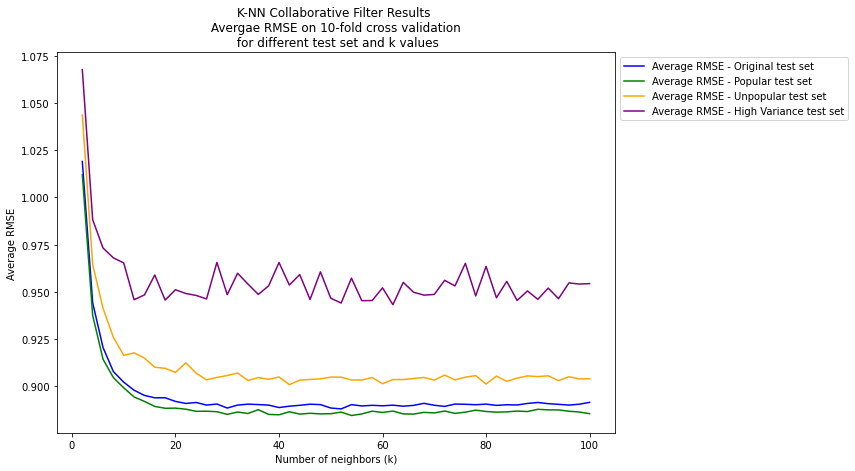

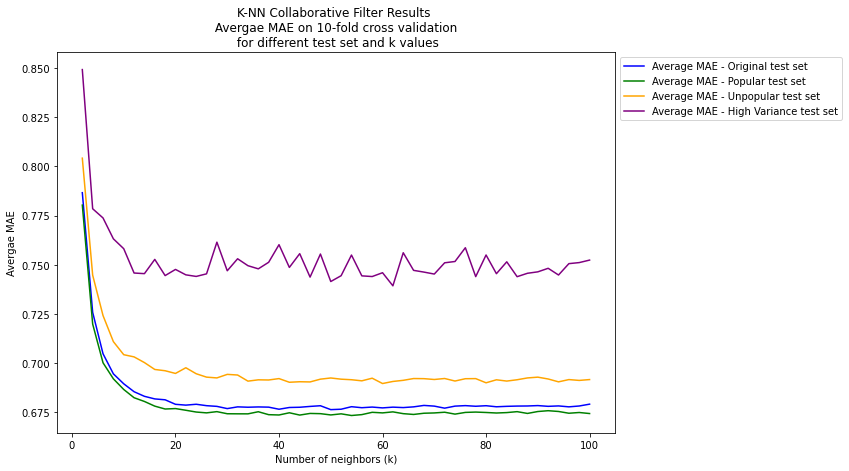

In [38]:
plot_dets_q6 = {
    'x_label': 'Number of neighbors (k)',
    'y_label': 'Average Test Error accross 10-fold CV'
}
k_range_q6 = list(range(2, 101, 2)) 
q6_knn_res_dfs = evaluate_model_on_trimsets(data=ratings_data,
                                                   model_type='KNN',
                                                   k_range=k_range_q6, 
                                                   plot_dets=plot_dets_q6, 
                                                   trim_types = [None, 'popular','unpopular','high_variance'],
                                                   is_plot=True, 
                                                   print_update=False)

In [88]:
q6_knn_res_df = pd.concat(q6_knn_res_dfs)
q6_knn_res_df_pivot = q6_knn_res_df.pivot_table(columns='k').T
display(q6_knn_res_df_pivot)
display(q6_knn_res_df_pivot.describe())
print('Min Avg RMSE and Avg MAE for each test set:')
print(q6_knn_res_df_pivot.min())

,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
k,,,,,,,,
2,0.849334,0.786651,0.780330,0.804224,1.067826,1.019113,1.012025,1.043699
4,0.778469,0.725708,0.719788,0.744675,0.988268,0.944187,0.937513,0.964471
6,0.773789,0.704645,0.700055,0.724103,0.973215,0.920493,0.914251,0.941319
8,0.763165,0.694420,0.691886,0.710823,0.968007,0.907706,0.904517,0.925878
10,0.758136,0.689355,0.686463,0.704164,0.965289,0.902073,0.899090,0.916294
12,0.745751,0.685317,0.682259,0.703050,0.945798,0.897826,0.894258,0.917615
14,0.745432,0.682974,0.680355,0.700153,0.948333,0.895068,0.891897,0.914878
16,0.752689,0.681653,0.677975,0.696647,0.958898,0.893794,0.889224,0.910009
18,0.744441,0.681203,0.676511,0.695994,0.945616,0.893812,0.888245,0.909444


,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.752294,0.682372,0.679014,0.696960,0.955938,0.895322,0.891301,0.910447
std,0.015929,0.017116,0.016575,0.018062,0.018347,0.020062,0.019481,0.021964
min,0.739239,0.676198,0.673206,0.689486,0.943163,0.887919,0.884409,0.900764
25%,0.745249,0.677472,0.674144,0.691160,0.947090,0.889820,0.885550,0.903458
50%,0.748019,0.677948,0.674713,0.691952,0.952033,0.890276,0.886465,0.904670
75%,0.754424,0.678453,0.675252,0.694065,0.958483,0.891202,0.887487,0.906608
max,0.849334,0.786651,0.780330,0.804224,1.067826,1.019113,1.012025,1.043699


Min Avg RMSE and Avg MAE for each test set:
avg_mae_high_variance     0.739239
avg_mae_original          0.676198
avg_mae_popular           0.673206
avg_mae_unpopular         0.689486
avg_rmse_high_variance    0.943163
avg_rmse_original         0.887919
avg_rmse_popular          0.884409
avg_rmse_unpopular        0.900764
dtype: float64


The minimum average RMSE for each test set:

- Original test min AVG RMSE:  0.887919
- Popular test set min AVG RMSE: 0.884409
- Unpopular test set min AVG RMSE: 0.900764
- High variance test set min AVG RMSE: 0.943163

When we look at the RMSE plots, we see that the best RMSE curve belongs to popular test set, even better than original one. This makes perfect sense, since populat test set only contains the movies that have ratings > 2. This means that models, can learn from at least 3 ratings and give good or at least closer predictions to the true rating hence lower the errors. The second best is original test set, which is everything included and unpopular and high variance test sets perform worse. This is again makes sense: for unpopular movie, the number of ratings movies received doesn't really help to predict ratings, and since it is very sparse may be causing overfitting and for the high variance case, this time the problem is that movies got very different ratings, and the big differences between the ratings, causes more trouble and confuses the model. The curve shapes has decreasing trend for original, popular and unpopular ones and reaches to plataeu. For unpopular one however curve is less steady compared the other two, and still has some changes. High variance curve on the other hand, is basically follows a zigzag trend, where the error rates ups and downs very quickly with the change of k. The min AVG. RMSE ratings for each model also shows that high variance set performs the worst.


#### KNN ROC Curves for each test set

For 4 different threshold values [2.5, 3, 3.5, 4], I plotted the ROC curve of each test set. The model used in KNNwithMeans and the number of neighbors (k) is the chosen value in question 5, k=22.

I also added the results for original test set as a reference point.

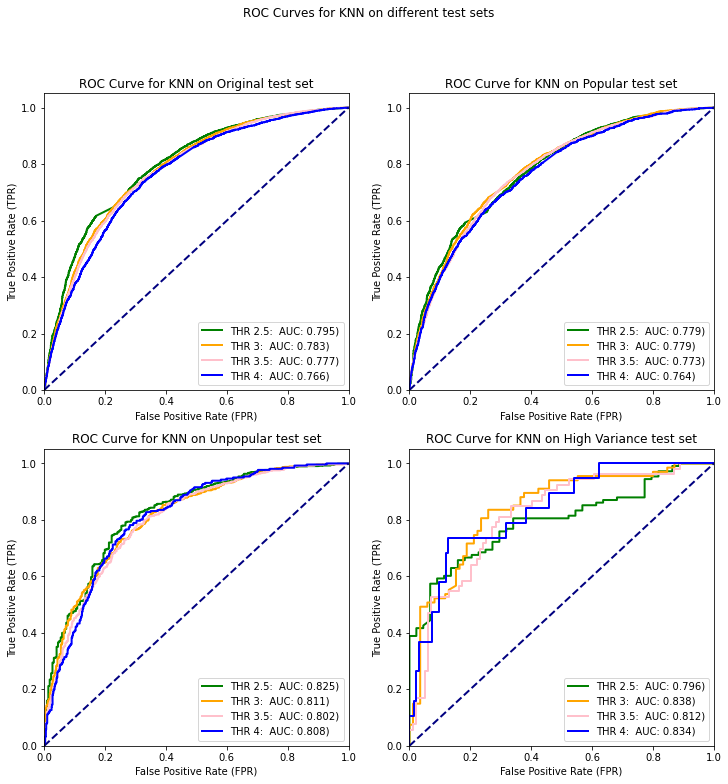

In [40]:
thresholds = [2.5, 3, 3.5, 4]
chosen_k = 22

multiple_rocs(data=ratings_data,
              model_type='KNN', 
              trim_types = [None, 'popular','unpopular','high_variance'],
              chosen_k=chosen_k, 
              thresholds=thresholds,
              suptitle='ROC Curves for KNN on different test sets')

The Area Under Curve results for each curve in each plot is stated in the legend of the plots.

From the results, for popular test set the threshold with best AUC is threshold=2.5 and 3 with AUC:0.779. The ROC curves and AUC scores for each tresholds for popular movies set are very close to each other. The threshold doesn't seem to make too much difference. For unpopular set, the AUC results are higher, around 0.8-0.82 range. Threshold 2.5 has the highes AUC 0.825, the curves are again similar, though less smoother compared the curves on popular set. For High variance test set, the ROC curves are kind of rectangular shape. The reason for this could be because there is a very low number of samples, 87, in the high variance set (popular and unpopular has more than 4.5K+). Because we are having very few samples for high variance set, the results might not be very reliable. The AUC range is from 0.79-0.838, best threshold is 3 with AUC 0.838.



## Model-based Collaborative Filtering

### Question 7

Understanding the NMF cost function: Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.

The optimization problem is not convex [1]. But it is rather a biconvex optimization problem, this means if we keep U fixed, than the problem is convex for V and we can minimize for V and if we keep V fixed, problem is convex again for U and we can minimize for U. Alternating Least Squares method helps us to iterate between keeping U fixed and solve for V and keeping V and solving for you, until the convergence reached. 

__For U fixed:__

We optimize for V.

Least-square problem in Equation 5 becomes:
      
\begin{equation} \min_{V} \sum_{i=1}^{m} \sum_{j=1}^{n}  W_{ij}(r_{ij} - (UV^T)_{ij})^2 \end{equation}


\begin{equation} \text{subject to } V \geq 0 \end{equation}
 
Equation 7 becomes:

\begin{equation} \min_{V} \sum_{i=1}^{m} \sum_{j=1}^{n}  W_{ij}(r_{ij} - (UV^T)_{ij})^2 + \lambda \|{U}\|_{F}^2 + \lambda \|{V}\|_{F}^2 \end{equation}


\begin{equation} \text{subject to } V \geq 0 \end{equation}


Given that U is fixed, U doesn't change and we apply non-negativity constraint on U when V fixed and we optimize for U.
[1]: Algorithms for Non-negative Matrix Factorization, Daniel D. Lee and H. Sebastian Seung, NIPS,2000.



We can show non-covexity of the optimization problem by a counter example:

Assume scalar case where m=n=k=1 and W, r, U and V all scalars. Let's assume also W=1, then the problem in equation 5 becomes \begin{equation} \min_{u,v \geq{0}}  (r - uv)^2 \end{equation}. By taking the Hessian of the equation we want to minimize, and using u=2, v=1 values, we can show that the hessian is not positive semidefinite for all u,v,r >= 0 and hence not convex.

### Question 8

#### Question 8.A Design NMF- Based Collaborative Filter

Design a NMF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes too long, you can increase the step size. Increasing it too much will result in poorer granularity in your results. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y- axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.


I used NMF model from surprise library to for the NMF collaborative filter. The plots below shows that Average RMSE and MAE results accross 10-fold for each k from 2 to 50, with step sizes 2.

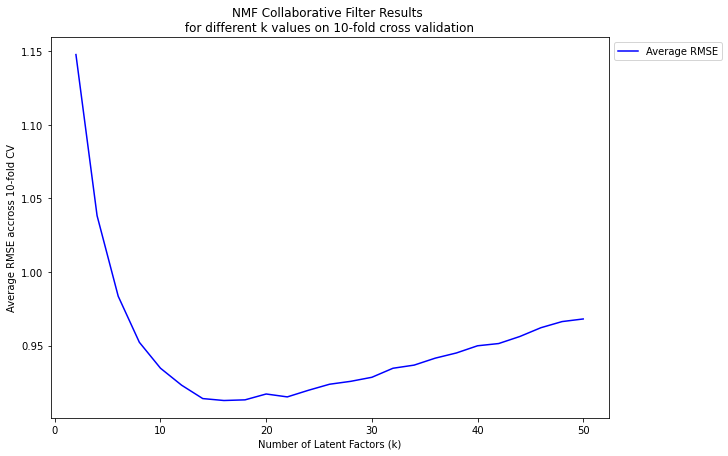

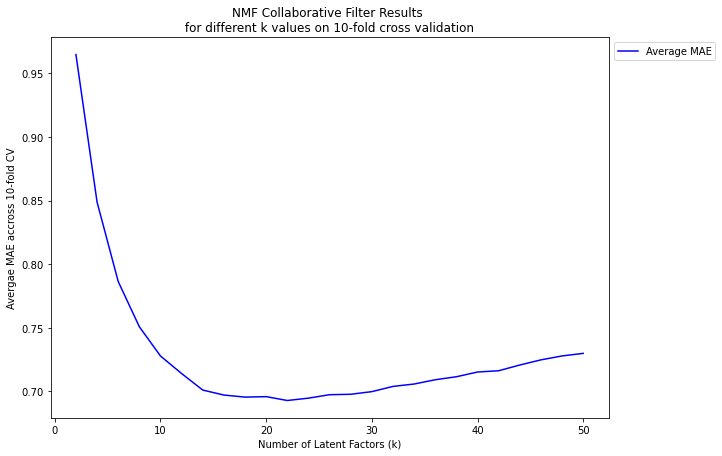

In [41]:
plot_dets_q8 = {
    'x_label': 'Number of Latent Factors (k)',
    'title': 'NMF Collaborative Filter Results \n for different k values on 10-fold cross validation '
}
k_range_q8 = list(range(2, 51, 2))
q8_exp_df = evaluate_model(data=ratings_data, model_type='NMF' ,k_range=k_range_q8, plot_dets=plot_dets_q8)

In [43]:
q8_exp_df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40
avg_rmse,1.14788,1.03832,0.98351,0.952192,0.934551,0.922999,0.913905,0.912593,0.913035,0.917021,0.915043,0.919551,0.923659,0.92563,0.928382,0.934531,0.93666,0.941402,0.944926,0.94981
avg_mae,0.964758,0.848743,0.786312,0.750722,0.727739,0.713942,0.700955,0.697028,0.695412,0.695784,0.692744,0.694595,0.697309,0.697638,0.699715,0.703823,0.705695,0.709069,0.711432,0.715143
cv_results,"{'test_rmse': [1.1582446282333843, 1.148348636...","{'test_rmse': [1.0388716477142774, 1.035961110...","{'test_rmse': [0.9914079911858433, 0.989344772...","{'test_rmse': [0.947944592380377, 0.9382680841...","{'test_rmse': [0.9274059360624644, 0.936343560...","{'test_rmse': [0.9271611637207541, 0.918365858...","{'test_rmse': [0.8984714837001442, 0.915702042...","{'test_rmse': [0.9145143320746897, 0.913201285...","{'test_rmse': [0.9109177142377667, 0.899319397...","{'test_rmse': [0.9238080510847194, 0.926809043...","{'test_rmse': [0.9192749622044434, 0.904355120...","{'test_rmse': [0.9314006561385201, 0.914919993...","{'test_rmse': [0.9460442651764495, 0.922322856...","{'test_rmse': [0.9245103333272665, 0.944730195...","{'test_rmse': [0.9134075627315653, 0.933350827...","{'test_rmse': [0.948791476853621, 0.9433635199...","{'test_rmse': [0.9382978335686227, 0.929346941...","{'test_rmse': [0.9313377266396836, 0.927886527...","{'test_rmse': [0.9536855353334757, 0.944631422...","{'test_rmse': [0.9468920277983701, 0.956834960..."


For NMF, we see that both MAE and RMSE curves follow similar trends, at first starts decreasing with increasing k, then starts to increase again after certain number of latent factors. The minimum error rates are when k is in 15-20 range.

#### Question 8.B 

Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

__Min Avg RMSE and MAE values for each k:__

In [45]:
q8_exp_df[['k','avg_rmse','avg_mae']]

,k,avg_rmse,avg_mae
0,2,1.147880,0.964758
1,4,1.038320,0.848743
2,6,0.983510,0.786312
3,8,0.952192,0.750722
4,10,0.934551,0.727739
5,12,0.922999,0.713942
6,14,0.913905,0.700955
7,16,0.912593,0.697028
8,18,0.913035,0.695412
9,20,0.917021,0.695784


__Number of Genres in the dataset:__

In [46]:
# Number of Genres in the dataset
gnr_list = movies.genres.apply(lambda x: x.split('|')).values.tolist()
genres = set(x for lst in gnr_list for x in lst)
print(len(genres))
print(genres)

20
{'Horror', '(no genres listed)', 'Documentary', 'Film-Noir', 'Thriller', 'Drama', 'Western', 'Fantasy', 'Crime', 'War', 'Adventure', 'Musical', 'Romance', 'Mystery', 'Sci-Fi', 'Animation', 'IMAX', 'Action', 'Comedy', 'Children'}


From the Q8-A plot and the values in the above table, we can see that the minimum errors happen:

- min Avg. RMSE = 0.912593 at k=16
- min Avg. MAE = 0.692744 at k=22

The optimal k value should be around 16-22 range. If we compare k=16 and k=22, k=22 seems to be a better choice since MAE is the lowest, and the difference of RMSE value at k=22 and minimum at k=16 is lower compared to choosing k=16 and having min RMSE and a higher difference between MAE scores between two k values.
On the other hand, if we care RMSE error more than MAE, k=16 can be chosen as optimal number of latent factors. 

For the following questions we will take k=22, since it has lowest MAE and a close to lowest RMSE score, and proceed with that.

The number of movie genres in the dataset is 20 (counting "no genres listed" as a genre, if not 19). The chosen number of latent factors is close but not same. 

#### Question 8.C

Performance on trimmed Test set subsets: For each of Popular, Unpopular and High- Variance test subsets 
- Design a NMF collaborative filter to predict the ratings of the movies in the trimmed test subset and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.
-  Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.
- Plot the ROC curves for the NMF-based collaborative filter designed in part A for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the optimal number of latent factors found in question B. For each of the plots, also report the area under the curve (AUC) value.

##### __Results of NMF on Original Test set and Popular, Unpopular, High Variance Trimmed Test Sets__

NMF with different values of latent factors fromm 2 to 50 with step size 2 is applied for each trimming type (popular, unpopular and high variance).
For different latent factors 10-fold cross validation is applied and avg rmse is created by averaging the RMSE results of 10-fold validations.

To be able to compare I also added the original test set in the plots. Original test set in this report refers to as no trimming applied to the test set. I also added the MAE scores out of curiosity. 

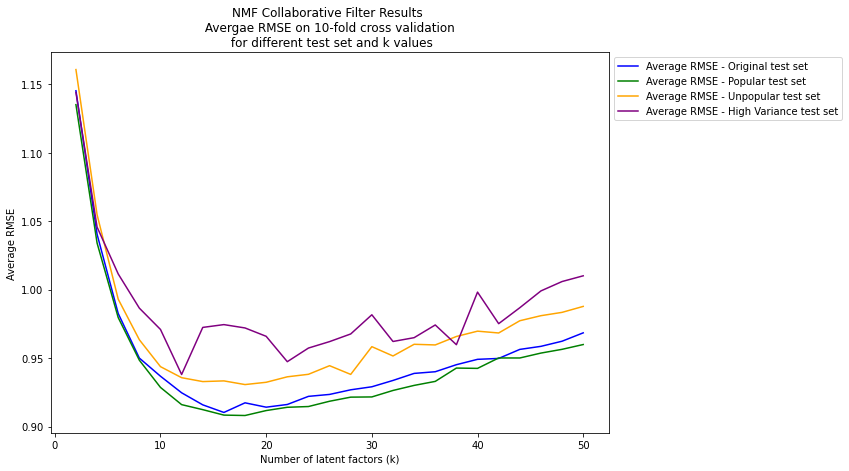

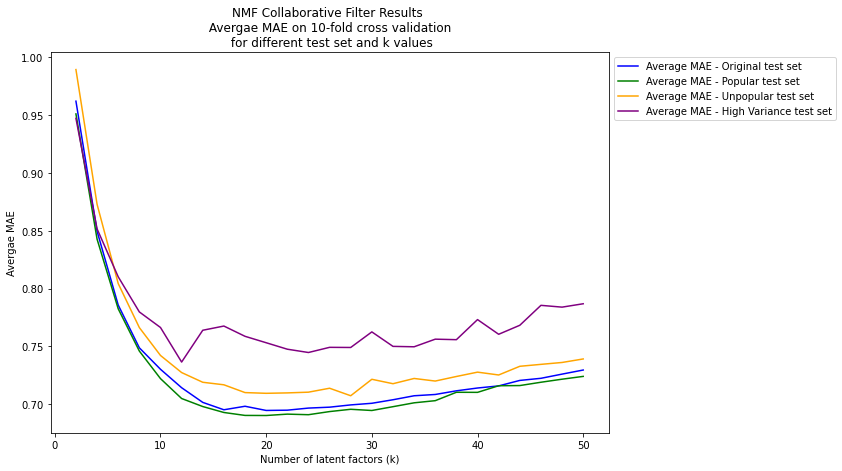

In [53]:
plot_dets_q8 = {
    'x_label': 'Number of latent factors (k)'
}
k_range_q8 = list(range(2, 51, 2)) 
q8_knn_res_dfs = evaluate_model_on_trimsets(data=ratings_data,
                                                   model_type='NMF',
                                                   k_range=k_range_q8, 
                                                   plot_dets=plot_dets_q8, 
                                                   trim_types = [None, 'popular','unpopular','high_variance'],
                                                   is_plot=True, 
                                                   print_update=False)

In [87]:
q8_knn_res_df = pd.concat(q8_knn_res_dfs)
q8_knn_res_df_pivot = q8_knn_res_df.pivot_table(columns='k').T
display(q8_knn_res_df_pivot)
display(q8_knn_res_df_pivot.describe())
print('Min Avg RMSE and Avg MAE for each test set:')
print(q8_knn_res_df_pivot.min())
q8_knn_res_df_pivot.to_csv('q8_knn_res_dfs.csv')

,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
k,,,,,,,,
2,0.947279,0.962131,0.951110,0.989477,1.143929,1.145154,1.135025,1.160615
4,0.851653,0.849588,0.842741,0.872891,1.045634,1.040371,1.033962,1.054709
6,0.810168,0.785723,0.782470,0.804304,1.011401,0.982511,0.979526,0.992989
8,0.779758,0.748722,0.745895,0.766223,0.986427,0.949962,0.948411,0.963353
10,0.766303,0.730156,0.722066,0.742107,0.970860,0.936710,0.928538,0.943703
12,0.736401,0.714199,0.704848,0.727309,0.937976,0.924625,0.915972,0.935643
14,0.763918,0.701502,0.697903,0.718906,0.972358,0.915820,0.912307,0.932804
16,0.767553,0.695109,0.692760,0.716717,0.974399,0.910265,0.908325,0.933305
18,0.758670,0.698148,0.690224,0.709980,0.971958,0.917291,0.908033,0.930619


,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.774288,0.729096,0.724186,0.743947,0.985288,0.950236,0.944646,0.967963
std,0.043327,0.059175,0.058044,0.062308,0.040364,0.049148,0.048360,0.048629
min,0.736401,0.694522,0.690149,0.707249,0.937976,0.910265,0.908033,0.930619
25%,0.749963,0.699315,0.694482,0.716717,0.964864,0.923424,0.915972,0.938046
50%,0.762490,0.711509,0.704848,0.723915,0.974138,0.938772,0.930013,0.959558
75%,0.779758,0.725963,0.721569,0.736040,0.998117,0.956298,0.950051,0.977222
max,0.947279,0.962131,0.951110,0.989477,1.143929,1.145154,1.135025,1.160615


Min Avg RMSE and Avg MAE for each test set:
avg_mae_high_variance     0.736401
avg_mae_original          0.694522
avg_mae_popular           0.690149
avg_mae_unpopular         0.707249
avg_rmse_high_variance    0.937976
avg_rmse_original         0.910265
avg_rmse_popular          0.908033
avg_rmse_unpopular        0.930619
dtype: float64




The minimum average RMSE for each test set:

- Original test min AVG RMSE:  0.910265
- Popular test set min AVG RMSE:  0.908033
- Unpopular test set min AVG RMSE: 0.930619
- High variance test set min AVG RMSE: 0.937976

In RMSE plots, the best RMSE curve belongs to popular test set, even better than original one. This makes sense, since popular test set only contains the movies that have ratings > 2, since this test set has lower sparsity compared to others, it helps to have better predictions. The second best is original test set, which is everything included and followed by unpopular and then high variance test sets being the worst one. For unpopular movie, the number of ratings for movies are really sparse, and for the high variance case, movie ratings given were very diverse, and the big differences between the ratings, causes more trouble to the model. 

The high level curve trends are similar for all 4 test set: first quick decrease in the error, then slower decrease in the error with higher ks, reaching a minimum error and then starting to have an increasing trend with the increase of k. The smoothness of the curves though is very different. Popular test set curve seems to be more stable and smooth, whereas unpopular one, has small up-down quick changes in the error trend, toward k=30 and the remaining of the experiment. The high variance test set though is very unstable error rates and not smooth after around k=10. trend, then after certain k  has decreasing trend for all original, popular and unpopular ones and reaches to plataeu. The min AVG. RMSE ratings for each model also shows that high variance set has the worst min AVG RMSE.

##### __NMF ROC Curves for each test set__

For 4 different threshold values [2.5, 3, 3.5, 4], I plotted the ROC curve of each test set. The model used in NMF and the number of latent factors (k) is the chosen value in question 8.B, k=22.

I also added the results for original test set as a reference point.

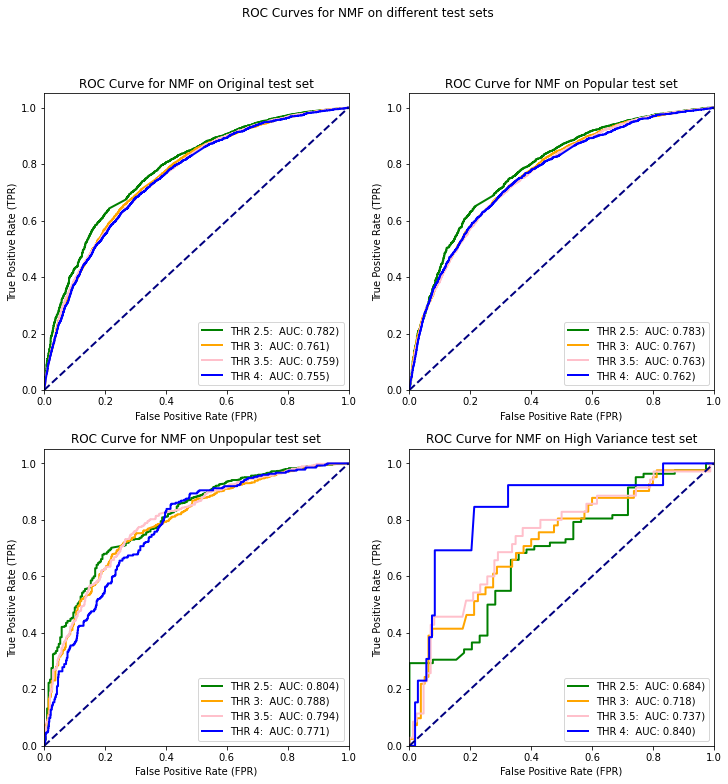

In [60]:
thresholds = [2.5, 3, 3.5, 4]
chosen_k = 22

multiple_rocs(data=ratings_data,
              model_type='NMF', 
              trim_types = [None, 'popular','unpopular','high_variance'],
              chosen_k=chosen_k, 
              thresholds=thresholds,
              suptitle='ROC Curves for NMF on different test sets')

The Area Under Curve results for each curve in each plot is stated in the legend of the plots.

From the results, for popular test set the threshold with best AUC is threshold=2.5 with AUC:0.783. The ROC curves and AUC scores for the rest of the tresholds for popular movies set are around 0.762-0.767 range. The threshold 2.5 AUC and curve seems better but without too much difference. For unpopular set, the AUC results are higher, around 0.771-0.804 range. Threshold 2.5 has the highest AUC 0.804, the curves are not similar, the main difference in the curves happen when the FPR rate is less than 0.4 and TPR less than around 0.8. The curves are also less smooth. For High variance test set, the ROC curves are in staircase shape. The reason for this could be because there is a very low number of samples, 87, in the high variance set (popular and unpopular has more than 4.5K+). Because we are having very few samples for high variance set, the results might not be very reliable. The AUC range is the most different betweeen the other sets, showing thresholding is more important for high variance case compared to the other ones. The AUC range is from 0.684-0.840, best threshold is 3 with AUC 0.84.


### Question 9

Interpreting the NMF model: Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?

I performed NMF k=20 for the whole dataset. In surprise library. model.pu is U (user-latent factors) and model.qi is V (movie/item latent factors). For each 20 column of V, I sort the movies by descending order and report the genre of the top 10 movies. Given movies belong to multiple genres, for each column's top 10 movies, I also counted the genre appearance and showed the counts.

In [61]:
# Retrieve the trainset
whole_train_set = ratings_data.build_full_trainset() 
q9_k = 20
model_nmf = NMF(n_factors=q9_k, random_state=rand_seed, verbose=0)         
model_nmf.fit(whole_train_set)
U = model_nmf.pu
V = model_nmf.qi

__V movie-latent factor interaction matrix preview:__

In [67]:
whole_train_set_iids = list(whole_train_set.all_items())
# print(f'pred_set iids are {pred_set_iids}')
iid_converter = lambda x: whole_train_set.to_raw_iid(x)
whole_train_set_raw_iids = list(map(iid_converter, whole_train_set_iids))

V_df = pd.DataFrame(V)
V_df['movId'] =  whole_train_set_raw_iids
display(V_df.head(5))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,movId
0,0.447124,0.606963,0.278229,0.832767,0.179741,0.022801,0.777665,0.434236,0.865774,0.371291,...,0.523433,0.934755,0.467175,0.431383,0.336084,0.594957,0.459337,0.244243,0.390941,112852
1,0.430486,0.108222,0.035439,0.205902,0.922796,1.236152,0.530992,0.077147,0.191823,0.453131,...,0.832344,0.060312,0.249052,0.637275,0.781580,0.395213,0.500689,0.345827,0.551321,1947
2,0.420501,0.030282,0.593468,0.119453,0.136894,0.166774,0.060199,0.143417,0.043376,0.261782,...,0.267348,0.374297,0.483580,0.301037,0.440614,0.160132,0.316761,0.382887,0.360784,1562
3,0.478775,0.440989,0.523445,0.254507,0.440463,0.539556,0.084055,0.345769,0.688219,0.289270,...,0.132848,0.659976,0.320904,0.718022,0.259715,0.647911,0.387552,0.568249,0.729041,2716
4,0.415930,0.924954,0.325614,0.487063,0.329309,0.620628,0.576291,0.512560,0.199223,0.034173,...,0.471218,0.562448,0.553170,1.011701,0.647172,0.442863,0.427108,0.277184,0.191529,88125


__Show first 3 V columns' top 10 movies id, title and genres:__

In [68]:
col_genres = []
for i in range(q9_k):   
    top_10_movies_for_column = list(V_df.sort_values(by=[i], ascending=False).movId[:10])
    movs = movies.set_index('movieId').loc[top_10_movies_for_column].reset_index(inplace=False)
    col_genres.append(movs.genres.values)
    if i < 2:
        print(f'---- Column {i} top 10 movies genres: ----')
        display(movs)

---- Column 0 top 10 movies genres: ----


,movieId,title,genres
0,70946,Troll 2 (1990),Fantasy|Horror
1,7116,Diabolique (Les diaboliques) (1955),Horror|Mystery|Thriller
2,7564,Kwaidan (Kaidan) (1964),Horror
3,130634,Furious 7 (2015),Action|Crime|Thriller
4,80126,"American, The (2010)",Drama|Thriller
5,2488,Peeping Tom (1960),Drama|Horror|Thriller
6,3223,"Zed & Two Noughts, A (1985)",Drama
7,1173,"Cook the Thief His Wife & Her Lover, The (1989)",Comedy|Drama
8,1606,Kull the Conqueror (1997),Action|Adventure
9,4794,Opera (1987),Crime|Horror|Mystery


---- Column 1 top 10 movies genres: ----


,movieId,title,genres
0,5480,Stuart Little 2 (2002),Children|Comedy
1,305,Ready to Wear (Pret-A-Porter) (1994),Comedy
2,2149,House II: The Second Story (1987),Comedy|Fantasy|Horror
3,32598,Fever Pitch (2005),Comedy|Romance
4,1376,Star Trek IV: The Voyage Home (1986),Adventure|Comedy|Sci-Fi
5,32892,Ivan's Childhood (a.k.a. My Name is Ivan) (Iva...,Drama|War
6,283,New Jersey Drive (1995),Crime|Drama
7,140711,American Ultra (2015),Action|Comedy|Sci-Fi|Thriller
8,54734,Sydney White (2007),Comedy
9,34332,Sky High (2005),Action|Adventure|Children|Comedy


__All V columns' top 10 movies genres:__

In [69]:
# Top 10 movies' genres for each V column
nmf_genres_per_column = pd.DataFrame(col_genres)
nmf_genres_per_column = nmf_genres_per_column.T
nmf_genres_per_column = nmf_genres_per_column.add_prefix('V_column_')
nmf_genres_per_column = nmf_genres_per_column.T.add_prefix('movie_')
nmf_genres_per_column = nmf_genres_per_column .T
nmf_genres_per_column

,V_column_0,V_column_1,V_column_2,V_column_3,V_column_4,V_column_5,V_column_6,V_column_7,V_column_8,V_column_9,V_column_10,V_column_11,V_column_12,V_column_13,V_column_14,V_column_15,V_column_16,V_column_17,V_column_18,V_column_19
movie_0,Fantasy|Horror,Children|Comedy,Comedy|Drama|Romance,Action|Sci-Fi,Action|Fantasy|Horror|Sci-Fi|Thriller,Animation|Children|Comedy|Musical,Children|Comedy|Fantasy|Romance,Action|Adventure|Sci-Fi,Action|Horror|Thriller,Fantasy|Western,Drama,Horror|Thriller,Drama|Sci-Fi,Comedy|Romance,Comedy|Romance,Drama|Fantasy|Mystery,Action|Fantasy|Horror|Sci-Fi|Thriller,Drama,Drama|Romance,Action|Comedy|Western
movie_1,Horror|Mystery|Thriller,Comedy,Comedy|Crime,Sci-Fi,Comedy|Romance,Adventure|Animation|Children|Comedy|IMAX,Action|Adventure|Animation,Drama|Romance,Children|Comedy,Comedy|Romance,Drama|Thriller,Animation|Comedy,Crime|Drama|Fantasy|Mystery|Thriller,Drama|Romance,Drama,Sci-Fi,Drama,Comedy,Comedy|Drama,Action|Adventure|Drama|Thriller
movie_2,Horror,Comedy|Fantasy|Horror,Action|Sci-Fi|Thriller,Horror|Sci-Fi,Drama,Horror|Thriller,Action|Comedy|Crime|Fantasy,Documentary,Comedy,Action|Crime|Sci-Fi|Thriller,Fantasy|Horror,Comedy|Drama,Horror|Thriller,Comedy|Horror,Crime|Horror|Mystery,Comedy|Drama,Horror,Comedy,Sci-Fi,Comedy|Documentary
movie_3,Action|Crime|Thriller,Comedy|Romance,Documentary,Comedy|Drama,Drama|Horror|Thriller,Comedy|Romance,Comedy|Drama,Action|Drama,Comedy,Adventure|Children,Drama|Romance|Thriller,Comedy|Drama|Romance,Comedy,Drama|Film-Noir,Drama,Drama|Thriller,Comedy|Drama,Action|Comedy|Sci-Fi,Drama|Romance|Thriller,Comedy
movie_4,Drama|Thriller,Adventure|Comedy|Sci-Fi,Documentary,Comedy,Action|Drama,Animation|Children|Comedy,Children|Comedy|Drama,Animation|Comedy,Comedy,Action|Adventure|Children|Fantasy,Comedy|Crime|Mystery|Romance,Adventure|Drama,Comedy,Action|Adventure|Animation|Children|Comedy,Horror|Mystery|Thriller,Drama|Romance,Crime|Drama|War,Adventure|Children|Comedy,Action|Sci-Fi,Comedy
movie_5,Drama|Horror|Thriller,Drama|War,Romance|Thriller,Action|Drama|Fantasy,Comedy|Fantasy,Horror,Comedy,Drama|Mystery,Drama|Romance,Comedy|Drama,Action|Adventure|Fantasy|Sci-Fi,Drama|War,Comedy|Drama,Horror|Thriller,Drama,Action|Drama|Fantasy,Animation|Comedy|Drama|Fantasy|Sci-Fi,Action|Sci-Fi|Thriller,Action|Comedy,Comedy
movie_6,Drama,Crime|Drama,Action|Children,Horror|Sci-Fi,Thriller,Action|Comedy|Crime,Action|Comedy|Crime|Thriller,Comedy|Fantasy|Horror|Musical|Thriller,Action|Adventure|Animation|Fantasy,Comedy,Drama|Mystery|Romance,Drama|Horror,Action|Drama,Comedy,Comedy|Drama|Horror,Comedy|Drama|Horror,Drama|Sci-Fi,Action|Sci-Fi,Drama|Thriller,Action|Drama|Sci-Fi
movie_7,Comedy|Drama,Action|Comedy|Sci-Fi|Thriller,Comedy,Action|Adventure|Animation|Children|Comedy|Rom...,Horror|Sci-Fi|Thriller,Comedy|Drama|Romance,Drama,Comedy|Romance,Fantasy|Romance|Thriller|IMAX,Drama|Mystery|Sci-Fi,Action|Adventure|Sci-Fi,Action|Adventure|Sci-Fi|Thriller,Drama,Adventure|Thriller,Drama|Thriller,Drama|Mystery|Sci-Fi,Action|Drama,Crime|Drama|Romance,Action|Comedy|Drama,Comedy
movie_8,Action|Adventure,Comedy,Comedy|Romance,Drama,Comedy|Documentary,Action|Comedy,Action|Comedy,Comedy|Drama|Romance,Horror,Children|Comedy|Fantasy,Horror,Crime|Drama,Horror|Thriller,Drama|Fantasy|Romance,Comedy|Horror,Comedy|Romance,Comedy,Comedy|Musical,Drama,Comedy|Romance
movie_9,Crime|Horror|Mystery,Action|Adventure|Children|Comedy,Drama|War,Drama|Romance|Western,Comedy|Crime,Comedy|Drama,Horror|Mystery,Drama|Romance,Adventure|Drama,Comedy|Drama,Action|Crime|Thriller,Drama|Horror|Thriller,Comedy,Crime|Drama|Mystery,Drama|Romance,Comedy|Romance,Drama,Drama|Romance,Comedy|Documentary,Comedy|Fantasy|Romance


__Genre counts for top 10 movies for all 20 V columns:__

In [70]:
for i in range(20):
    genres_per_column = '|'.join(nmf_genres_per_column[f'V_column_{i}'].tolist())
    genres = genres_per_column.split('|')
    genre_count = Counter(genres)
    genre_count = sorted(genre_count.items(), key=lambda pair: pair[1], reverse=True)
    genre_print = f'Column {i}: \n'+f'\tDistinct Genres: {len(genre_count)}\n\t' +(' '.join([ n+':'+str(c) for (n, c) in genre_count])  )
    print(genre_print)

Column 0: 
	Distinct Genres: 9
	Horror:5 Thriller:4 Drama:4 Mystery:2 Action:2 Crime:2 Fantasy:1 Comedy:1 Adventure:1
Column 1: 
	Distinct Genres: 12
	Comedy:8 Children:2 Adventure:2 Sci-Fi:2 Drama:2 Action:2 Fantasy:1 Horror:1 Romance:1 War:1 Crime:1 Thriller:1
Column 2: 
	Distinct Genres: 10
	Comedy:4 Romance:3 Drama:2 Action:2 Thriller:2 Documentary:2 Crime:1 Sci-Fi:1 Children:1 War:1
Column 3: 
	Distinct Genres: 11
	Sci-Fi:4 Drama:4 Action:3 Comedy:3 Horror:2 Romance:2 Fantasy:1 Adventure:1 Animation:1 Children:1 Western:1
Column 4: 
	Distinct Genres: 10
	Thriller:4 Comedy:4 Horror:3 Drama:3 Action:2 Fantasy:2 Sci-Fi:2 Romance:1 Documentary:1 Crime:1
Column 5: 
	Distinct Genres: 12
	Comedy:8 Animation:3 Children:3 Horror:2 Romance:2 Action:2 Drama:2 Musical:1 Adventure:1 IMAX:1 Thriller:1 Crime:1
Column 6: 
	Distinct Genres: 12
	Comedy:7 Action:4 Drama:3 Children:2 Fantasy:2 Crime:2 Romance:1 Adventure:1 Animation:1 Thriller:1 Horror:1 Mystery:1
Column 7: 
	Distinct Genres: 13
	Dra


__Do the top 10 movies belong to a particular or a small collection of genre?__
For V columns, latent factors, Top 10 movies doesn't belong to a particular genre but majority indeed belongs to a small collection of genres. For example, in column 0 (first column of V) we can see that the top 10 movies are tagged with 9 distinct genres but the top 3 genres are Horror:5 Thriller:4 Drama:4. We can see that the column 0 latent factor can be represented by a small collection of genres: Horror, Thriller and Drama movies. Similarly column 1 (second column of V) has 9 comedy movie tags out of 10 movies, which can also show second latent factor has a connection with comedy genre. We can see the similar small collection of genres for each latent factor in the above results.

__Is there a connection between the latent factors and the movie genres?__
One of the advantages of NMF is being interpretable, in this specific case, I cannot see a one-to-one mapping with movie genres and latent factors. However, from the above observation, we can say that latent factors have a close connection betwen a small collection of genres. This shows that NMF with the use of latent factors, aggregate movies with similar genres together, and this can improve the recommendations, since this means that model implicitly finds and groups movies with similar collection of genres together and then use latent factors found to do recommendations accordingly.


### Question 10

#### Question 10.A Design MF with bias Collaborative Filter

Design a MF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

I used MF with bias=True model from surprise library for the MF with bias collaborative filter. The plots below shows that Average RMSE and MAE results accross 10-fold for each k from 2 to 50, with step sizes 2.

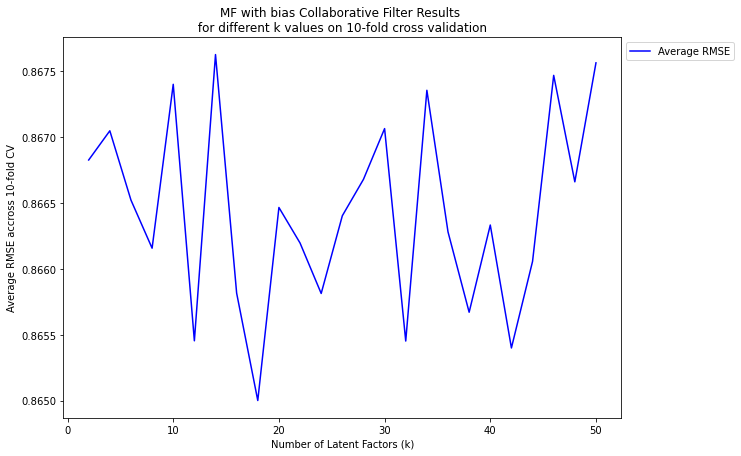

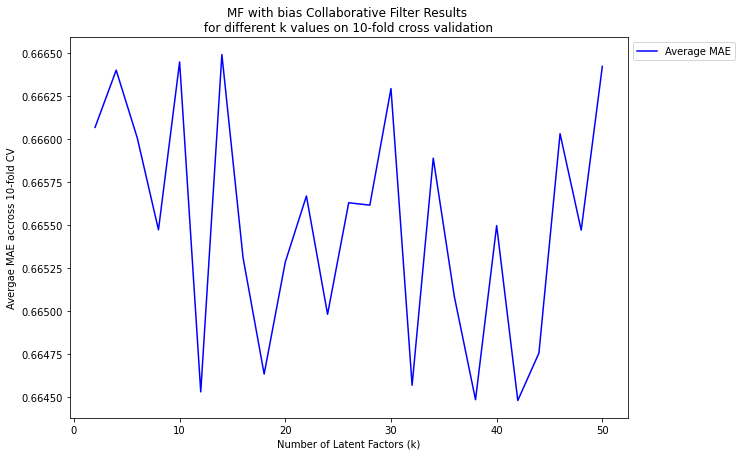

In [73]:
plot_dets_q10 = {
    'x_label': 'Number of Latent Factors (k)',
    'title': 'MF with bias Collaborative Filter Results \n for different k values on 10-fold cross validation '
}
k_range_q10 = list(range(2, 51, 2))
q10_exp_df = evaluate_model(data=ratings_data, model_type='MF' ,k_range=k_range_q10, plot_dets=plot_dets_q10)

In [74]:
q10_exp_df.T.head(20)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
k,2,4,6,8,10,12,14,16,18,20,...,32,34,36,38,40,42,44,46,48,50
avg_rmse,0.866823,0.867044,0.866519,0.866155,0.867397,0.865453,0.867622,0.865814,0.865,0.866463,...,0.865451,0.867351,0.866278,0.865669,0.86633,0.865399,0.866054,0.867464,0.866658,0.867559
avg_mae,0.666068,0.6664,0.666005,0.665472,0.666448,0.66453,0.666491,0.665311,0.664633,0.665285,...,0.664568,0.665889,0.665083,0.664484,0.665496,0.664479,0.664755,0.666031,0.66547,0.666422
cv_results,"{'test_rmse': [0.8505212855376368, 0.859773023...","{'test_rmse': [0.8566202719465758, 0.884161999...","{'test_rmse': [0.869473175027997, 0.8640233258...","{'test_rmse': [0.8657014393352603, 0.862854542...","{'test_rmse': [0.8560840212279571, 0.868503524...","{'test_rmse': [0.8832030677119755, 0.866466465...","{'test_rmse': [0.860445987482174, 0.8637839273...","{'test_rmse': [0.858549808253296, 0.8663017184...","{'test_rmse': [0.8557297531947884, 0.866998337...","{'test_rmse': [0.866497367725416, 0.8648418851...",...,"{'test_rmse': [0.8621914707139953, 0.863649863...","{'test_rmse': [0.8630598507035923, 0.876562045...","{'test_rmse': [0.864160098123739, 0.8675364609...","{'test_rmse': [0.8758539930195344, 0.867151063...","{'test_rmse': [0.8667798957130418, 0.850439021...","{'test_rmse': [0.8735050572975925, 0.860401127...","{'test_rmse': [0.858892899775938, 0.8716084419...","{'test_rmse': [0.8789551673500143, 0.865186731...","{'test_rmse': [0.8720384805525286, 0.870047159...","{'test_rmse': [0.8684046427135248, 0.878614088..."


For MF with bias, we again see that both MAE and RMSE curves follow similar trends. However, this time the error curves are very different than the previous models we saw. The curve has up and downs and follows a zig zag trend in the error values for different k values. However, if we look closely we can see that the y axis range is very small. The error range for MAE changes between 0.6665-0.6645 which means in the third decimal point and for RMSE curve, the error values are changing between 0.8675-0.8650 which is again in the third decimal point. By taking this into account, we can say that the error ranges are very small, compared to the KNN and NMF models, and MF with Bias also starts with very low error values even in the low k values. It also performs better compared to the other models given that even from start the AVG error metrics were way lower than the min AVG metrics we saw for the previous models.

#### Question 10.B 

Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

__Min Avg RMSE and MAE values for each k:__

In [75]:
q10_exp_df[['k','avg_rmse','avg_mae']]

,k,avg_rmse,avg_mae
0,2,0.866823,0.666068
1,4,0.867044,0.666400
2,6,0.866519,0.666005
3,8,0.866155,0.665472
4,10,0.867397,0.666448
5,12,0.865453,0.664530
6,14,0.867622,0.666491
7,16,0.865814,0.665311
8,18,0.865000,0.664633
9,20,0.866463,0.665285


From the Q10-A plot and the values in the above table, we can see that the minimum errors happen:

- min Avg. RMSE = 0.865000 at k = 18
- min Avg. MAE = 0.664479 at k = 42

The optimal k value chosen is 18, since it falls in the min avg RMSE and its corresponding MAE score is also very close to min AVG MAE. 
For the following questions I will take chosen k as k=18 for MF with Bias model.

From Question 8.B we know that the number of genres in the dataset is 20 (if we count "no genres listed" as a genre), the chosen number of latent factors is close 18 but not the same. 


#### Question 10.C

Performance on Test set subsets: For each of Popular, Unpopular and High-Variance test subsets 

-  Design a MF collaborative filter to predict the ratings of the movies in the trimmed test subset and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.
-  Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

Plot the ROC curves for the NMF-based collaborative filter designed in part A for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the optimal number of latent factors found in question B. For each of the plots, also report the area under the curve (AUC) value.

##### __Results of MF with bias on Original Test set and Popular, Unpopular, High Variance Trimmed Test Sets__

For MF with bias model, I used different values of latent factors fromm 2 to 50 with step size 2 and applied them for each trimming type (popular, unpopular and high variance). For different latent factors 10-fold cross validation is applied and avg rmse is created by averaging the RMSE results of 10-fold validations.

To be able to compare I also added the original test set in the plots. Original test set in this report refers to as no trimming applied to the test set. I also added the MAE scores out of curiosity. 

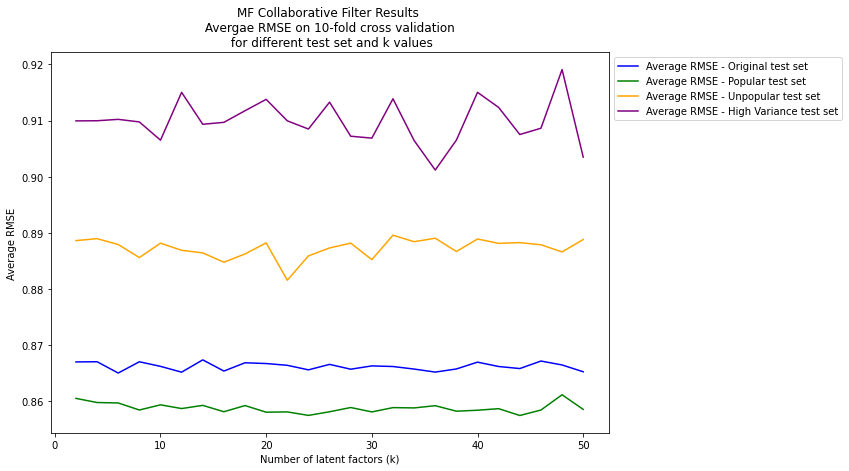

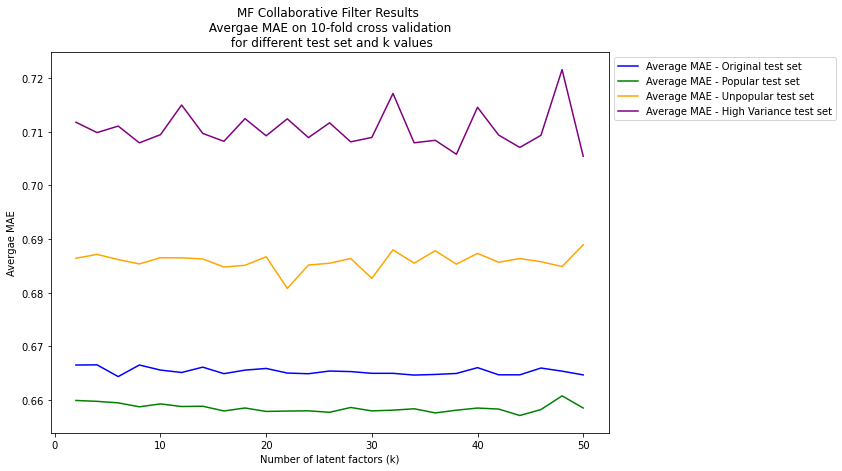

In [82]:
plot_dets_q10 = {
    'x_label': 'Number of latent factors (k)'
}
k_range_q10 = list(range(2, 51, 2))
q10_mf_res_dfs = evaluate_model_on_trimsets(data=ratings_data,
                                                   model_type='MF',
                                                   k_range=k_range_q10, 
                                                   plot_dets=plot_dets_q10, 
                                                   trim_types = [None, 'popular','unpopular','high_variance'],
                                                   is_plot=True, 
                                                   print_update=False)

In [96]:
q10_mf_res_df = pd.concat(q10_mf_res_dfs)
q10_mf_res_df_pivot = q10_mf_res_df.pivot_table(columns='k').T
display(q10_mf_res_df_pivot)
display(q10_mf_res_df_pivot.describe())
print('Min Avg RMSE and Avg MAE for each test set:')
print(q10_mf_res_df_pivot.min())
q10_mf_res_df_pivot.to_csv('q10_mf_res_df_pivot.csv')

,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
k,,,,,,,,
2,0.711792,0.666488,0.659876,0.686406,0.909938,0.866971,0.860473,0.888600
4,0.709859,0.666520,0.659712,0.687134,0.909964,0.867009,0.859735,0.888946
6,0.711074,0.664332,0.659431,0.686160,0.910214,0.864992,0.859657,0.887904
8,0.707949,0.666491,0.658691,0.685348,0.909756,0.867000,0.858402,0.885574
10,0.709473,0.665546,0.659237,0.686512,0.906505,0.866183,0.859322,0.888142
12,0.715006,0.665097,0.658746,0.686485,0.915025,0.865148,0.858662,0.886870
14,0.709709,0.666092,0.658801,0.686286,0.909334,0.867340,0.859228,0.886406
16,0.708228,0.664878,0.657918,0.684772,0.909682,0.865345,0.858095,0.884748
18,0.712462,0.665537,0.658470,0.685101,0.911751,0.866820,0.859193,0.886218


,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.710470,0.665308,0.658477,0.685872,0.909833,0.866171,0.858747,0.887271
std,0.003617,0.000650,0.000815,0.001635,0.003911,0.000709,0.000864,0.001769
min,0.705447,0.664332,0.657070,0.680774,0.901176,0.864992,0.857422,0.881535
25%,0.708228,0.664865,0.657930,0.685311,0.907208,0.865676,0.858095,0.886406
50%,0.709397,0.665097,0.658327,0.686160,0.909756,0.866183,0.858640,0.887904
75%,0.711792,0.665851,0.658746,0.686512,0.912335,0.866820,0.859193,0.888404
max,0.721616,0.666520,0.660735,0.688922,0.919087,0.867340,0.861115,0.889561


Min Avg RMSE and Avg MAE for each test set:
avg_mae_high_variance     0.705447
avg_mae_original          0.664332
avg_mae_popular           0.657070
avg_mae_unpopular         0.680774
avg_rmse_high_variance    0.901176
avg_rmse_original         0.864992
avg_rmse_popular          0.857422
avg_rmse_unpopular        0.881535
dtype: float64


The minimum average RMSE for each test set:

- Original test min AVG RMSE:  0.864992
- Popular test set min AVG RMSE: 0.857422
- Unpopular test set min AVG RMSE: 0.881535
- High variance test set min AVG RMSE: 0.901176

For the test sets we again see the same order popular has best results with lowest min avg RMSE with 0.857422 and overall curve. Followed by original set, unpopular and then high variance set. One difference in the RMSE and MAE plots above from the other models is actually MF with Bias, starts with relatively lower error values and curves have a very small decreasing slope, even like plateau since the error changes mostly happens in 2nd-3rd decimal points. The popular and original plots are more stable where unpopular and high variance sets follow more zigzags during the experiment. 

##### __MF with Bias ROC Curves for each test set__

For 4 different threshold values [2.5, 3, 3.5, 4], I plotted the ROC curve of each test set. The model used in MF with bias and the number of latent factors (k) is the chosen value in question 10.B, k=18.

I also added the results for original test set as a reference point.

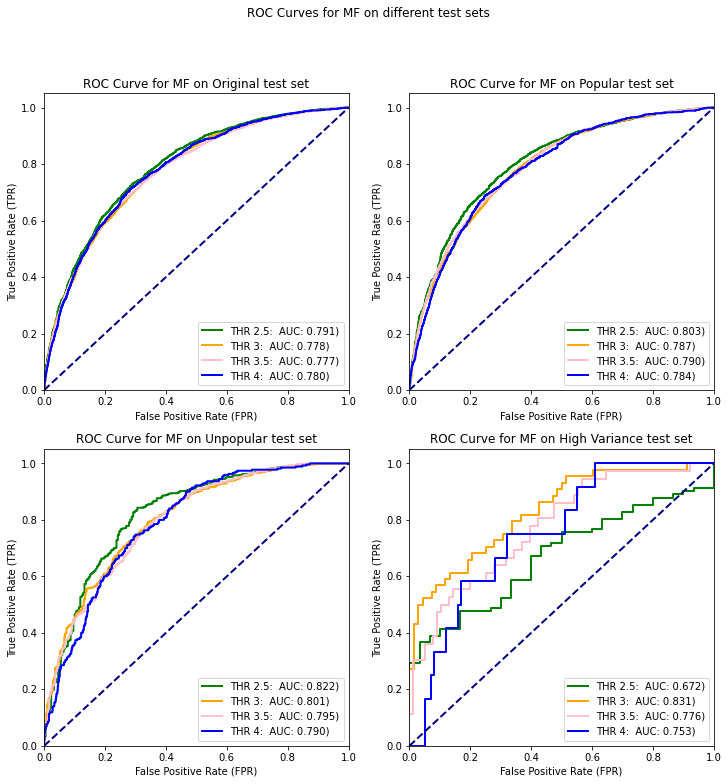

In [79]:
thresholds = [2.5, 3, 3.5, 4]
chosen_k_q10 = 18

multiple_rocs(data=ratings_data,
              model_type='MF', 
              trim_types = [None, 'popular','unpopular','high_variance'],
              chosen_k=chosen_k_q10, 
              thresholds=thresholds,
              suptitle='ROC Curves for MF on different test sets')

The Area Under Curve results for each curve in each plot is stated in the legend of the plots.

From the results, Popular set again has the smoother curves and the difference betweeen the AUC of the thresholds are not too different in the range of 0.784-0.803. This means for popular set any threshold may result in similar results but threshold 2.5 is the best (similar to previous models). Unpopular threshold curve differences are more clear compared to previous models ranging from 0.790 to 0.822. The best threshold for unpopular test set in again 2.5 with AUC 0.822. For high variance set the curves are drastically different and staircase shaped. The best threshold seems like 3 with AUC 0.31 and the worst one is 2.5 with 0.672 AUC. However, as we stated in the previous questions high variance test set has very few samples, 87, which might explain the stair-like curve appearance and the threshold choice and ROC curve might not be very reliable.

## Naive collaborative filtering

### Question 11

__Designing a Naive Collaborative Filter:__

- Design a naive collaborative filter to predict the ratings of the movies in the original dataset
and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by
averaging the RMSE across all 10 folds. Report the average RMSE.
Note that in this case, when performing the cross-validation, there is no need to calculate μ ’s i
for the training folds each time. You are only asked to use a single set of μ ’s calculated on i
the entire dataset and validate on 10 validation folds.
- Performance on Test set subsets: For each of Popular, Unpopular and High-Variance test subsets -
    - Design a naive collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation.
    - Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

For Naive Collaborative filter, I created a ratings_per_user pandas dataframe shown below, ratings_per_user is raw ratings data grouped by users and rating shows the mean rating for each user calculated on the entire dataset. I also created a get_naive_predictions_from_test function where it takes the ratings_per_user dataframe and test set, it returns the average user rating for each user in the test set. The result of this function is used as the predictions of the test set.

__ratings_per_user preview 10 predictions:__

calculates mean ratings for each user which will be used as naive collab. filter predictions

In [84]:
# Naive Collaborative Filter
ratings_per_user = pd.DataFrame(ratings_raw.groupby(by='userId').agg(mean_rating=('rating', 'mean'))).reset_index()
ratings_per_user.head(10).T

,0,1,2,3,4,5,6,7,8,9
userId,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.00000,10.000000
mean_rating,4.368534,3.948276,2.435897,3.555556,3.636364,3.493631,3.230263,3.574468,3.26087,3.278571


__Some stats on the ratings_per_user dataframe__

As seen from below the mean prediction is 3.65 where min assigned prediction is 1.275 and max is 5

In [95]:
ratings_per_user.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,610.0,305.500000,176.236111,1.000,153.25,305.500000,457.7500,610.0
mean_rating,610.0,3.657226,0.480641,1.275,3.36,3.694385,3.9975,5.0


In [85]:
def get_naive_predictions_from_test(ratings_per_user, test_set):
    preds = []
    for t in test_set:
        preds.append(ratings_per_user[ratings_per_user.userId==t[0] ].mean_rating.values[0])
    return preds

def perform_naive_cf(data, ratings_per_user, test_type=None):
    rmses, maes = [],[]
    kf = KFold(n_splits=10)
    for train_set, test_set in kf.split(data):
        if not test_type:
            trimmed_test= test_set
        else:
            trimmed_test = clean_based_on_trim_type(data=test_set, trim_type=test_type)
    
        preds = get_naive_predictions_from_test(ratings_per_user, trimmed_test)
        y_true = [t[2] for t in trimmed_test]
        rmses.append(mean_squared_error(y_true, preds, squared=False)) # squared false returns RMSE
        maes.append(mean_absolute_error(y_true, preds))
    avg_rmse = np.mean(rmses)
    avg_mae = np.mean(maes)
    if not test_type:
        test_type='original'
    print(f'Naive Collaborative Filter on {test_type.capitalize()} Average RMSE: {avg_rmse}')
    print(f'Naive Collaborative Filter on {test_type.capitalize()} Average MAE: {avg_mae}')
    return rmses, maes

For all 4 test set, original (no trim) , popular, unpopular and high_variance, I performed Naive Colab. Filter with 10-fold cross validation, average RMSE is calculated for each by averaging the RMSE results across all 10 folds.
The results are following:

In [86]:
dic_naive= {}
for trim_t in [None, 'popular', 'unpopular', 'high_variance']:
    rmses, maes = perform_naive_cf(data=ratings_data, 
                                   ratings_per_user=ratings_per_user,
                                   test_type=trim_t)
    if not trim_t:
        dic_naive['original']= {'mean_rmse':np.mean(rmses), 'mean_mae':np.mean(maes), 'rmses':rmses, 'maes':maes}
    else:
        dic_naive[trim_t]= {'mean_rmse':np.mean(rmses), 'mean_mae':np.mean(maes),'rmses':rmses, 'maes':maes}
    

Naive Collaborative Filter on Original Average RMSE: 0.934663052844902
Naive Collaborative Filter on Original Average MAE: 0.7289328699138828
Naive Collaborative Filter on Popular Average RMSE: 0.9250802897934453
Naive Collaborative Filter on Popular Average MAE: 0.7214231849077074
Naive Collaborative Filter on Unpopular Average RMSE: 0.9705068660276013
Naive Collaborative Filter on Unpopular Average MAE: 0.7561299367998391
Naive Collaborative Filter on High_variance Average RMSE: 0.9211233251598134
Naive Collaborative Filter on High_variance Average MAE: 0.7192754474476302


Naive Collab Filter:

- Original set Average RMSE:  0.934663052844902
- Popular set Average RMSE: 0.9250802897934453
- Unpopular set Average RMSE: 0.9705068660276013
- High Variance set Average RMSE: 0.9211233251598134

The Average RMSE results are mostly worse than the previous models min AVG RMSE results, but the results are not too different. This shows that even using this simple idea of averaging users previous ratings and used that as a recommended rating can give somewhat acceptable performance. The most interesting thing in this result if the Avg. RMSE of high variance set, in all the previous models, this set was the worst error rates, however in this model it is even better than the original set. My guess is that when the variance is too high between movie ratings, the mean find by the naive algorithm will be in the middle ratings, 3ish, showing moderate interest in the movie rather than strong preference, which will decrease the squared error of RMSE. For example, let's say we have a movie with 0.5 and 5, 2 total ratings, the recommended mean will be 2.75, which is moderate interest, there is no strong preference. So, even if the prediction is wrong the squared difference for different movies, will stay lower, compared than guessing 0.5 for a 5, high true rating.

## Performance Comparison

### Question 12

Comparing the most performant models across architecture: Plot the best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.

In [89]:
def plot_performant_model_roc_curves(data, model_types, chosen_ks, threshold):
    train_data, test_data = train_test_split(data, test_size=0.1)
    fprs, tprs, auc_scores = [],[],[]
    for model_t, k in  zip(model_types, chosen_ks):
        model = get_model(model_type=model_t, k=k)
        model.fit(train_data)
        preds = model.test(test_data)

        preds_vals = [pred.est for pred in preds]
        #preds_vals_thresholded = [1 if pred.est > threshold else 0 for pred in preds ]
        ground_truth_thresholded = [1 if pred.r_ui > threshold else 0 for pred in preds ]

        fpr, tpr, ths = roc_curve(y_true=ground_truth_thresholded, y_score=preds_vals)
        auc_score_res = auc(fpr, tpr)
        fprs.append(fpr)
        tprs.append(tpr)
        auc_scores.append(auc_score_res)

    plot_roc2(fprs=fprs, tprs=tprs, thresholds=threshold, aucs=auc_scores, 
              model_types=model_types, chosen_ks=chosen_ks, 
              title=f'ROC Curves for Performant Models \n threshod: {threshold}')

    return fprs, tprs, auc_scores

def plot_roc2(fprs, tprs, thresholds, aucs, model_types, chosen_ks, title=''):
    lw = 1
    colors = ['green', 'orange','pink']
    
    plt.figure(figsize=(7,7))
    for i in range(len(model_types)):
        plt.plot(
            fprs[i],
            tprs[i],
            color=colors[i],
            lw=lw,
            label=f"THR {model_types[i]} - k: {chosen_ks[i]}:  AUC: {aucs[i]:.3f})",
        )


    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.show()
  

I plotted the best ROC curves with threshold 3 for performant models on KNN, NMF and MF with their chosen k values: 22, 22, 18 respectively.

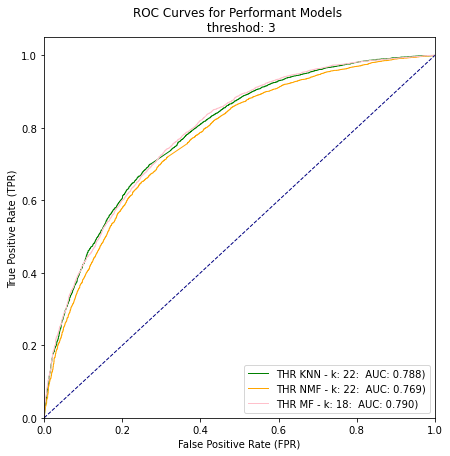

In [93]:
fprs, tprs, auc_scores = plot_performant_model_roc_curves(data=ratings_data, 
                                                           model_types=['KNN','NMF','MF'], 
                                                           chosen_ks=[22,22,18],
                                                           threshold=3)

The ROC curves are close together and smooth, we can seee that yellow one, NMF is slightly worse than the other two. MF with bias has the best AUC with 0.79, hence best at predicting movie ratings among the rest of the models, followed by KNN with 0.788, followed by NMF with 0.769. The differences between KNN and MF with bias is very low and either model could be a good choice for movie ratings. 

## Ranking

### Question 13

Understanding Precision and Recall in the context of Recommender Systems: Precision and Recall are defined by the mathematical expressions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words.


Relevant items to the user is where ground truth is positive, which means movies liked by user.

__Precision:__ 
        $$Precision(t) = \frac{|S(t)\cap  G |}{|S(t)|}$$

Precision is the amount of movies where intersection of recommended movies by system and ground truth positives (liked by user) over number of recommended movies. The metrics meaning is: what rate (percentage) of the recommended items is also liked by the user. In another words, it checks how relevant the recommended items to the user by comparing it against the ground truth positives. This metric helps us to understand how good the recommended items.


__Recall:__ 
        $$Recall(t) = \frac{|S(t)\cap  G |}{|G|}$$

Recall is the amount of movies where intersection of recommended movies by system and ground truth positives (liked by user) over grounf truth positives. It tells what rate (percentage) of movies liked by the user is in recommmended items list. In another words, it checks the percentage of relevant items being recommended to the user. Recall helps us understand how good the recommender model in finding/recommending items liked by the user. 


### Question 14

Understanding Precision and Recall in the context of Recommender Systems: Precision and Recall are defined by the mathematical expressions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words.

In this question, I used KNN, NMF and MF with bias models with their chosen ks (22,22,18 respectively) to plot individual and combined Precision vs t, Recall vs t and Precision Recall curves. I thresholded the Ground Truth values with 3, and assigned 1 for the movies higher than 3 and 0 for the ones lower or equal to 3. When creating the ground truth positives (G) list, for test set, I discarded the users whose |G| = 0, they didn't like any movie. I also dropped the users who rated less than t movies, for the test set on t. 

The experiment is ran t from 1 to 25 by stepsizes 1. I applied 10 cross validation for each t and average the Precision and Recall values. The Precision and Recall is calculated for each t by using precision_recall_at_t_per_user method I wrote. What the method does, given predictions, t value and a threshold, it returns a average user precision and average user recall. 

In [97]:
def precision_recall_at_t_per_user(preds, t, threshold=3,display_df=False):

    pred_df = pd.DataFrame(preds)
    pred_df['G']= pred_df.r_ui > threshold
    pred_df.G = pred_df.G.astype(int)

    # If |G| = 0 for some user in the test set, then drop this user, user didn't like any items in this test set
    uid_G_count = pd.DataFrame(pred_df.groupby('uid').G.sum()).reset_index()
    uid_G_count.rename(columns={'G':'G_sum'}, inplace=True)
    drop_users_lenG_0 = uid_G_count[uid_G_count.G_sum==0].uid.values

    # If some user in the test set has rated less than t items, then drop this user
    uid_rating_count = pd.DataFrame(pred_df.groupby('uid').r_ui.count()).reset_index()
    uid_rating_count.rename(columns={'r_ui':'rating_count'}, inplace=True)
    uid_rating_count_drop = uid_rating_count[uid_rating_count.rating_count < t].uid.values

    #print(pred_df.shape)
    pred_df_cleaned = pred_df[(~pred_df.uid.isin(uid_rating_count_drop)) & (~pred_df.uid.isin(drop_users_lenG_0))]
    #print(pred_df_cleaned.shape)

    # G: The set of items liked by the user (ground-truth positives)
    G_df = pred_df_cleaned[pred_df_cleaned.G == 1]
    G_df_list = G_df.groupby('uid')['iid'].apply(list).reset_index(name='liked_items')

    # S(t) : The set of items of size t recommended to the user. In this recommended set, ignore
    # (drop) the items for which we don’t have a ground truth rating.
    pred_df_cleaned = pred_df_cleaned.sort_values(by=['uid', 'est'], ascending=[True,False])
    S_list = pred_df_cleaned.groupby('uid')['iid'].apply(list).reset_index(name='rec_order_items')
    S_list['rec_t_items'] = S_list.rec_order_items.apply(lambda x: x[:t])

    uid_res = pd.merge(S_list, G_df_list)
    uid_res['user_precision_at_t'] = uid_res.apply(lambda x: len(set(x[2]).intersection(set(x[3])))/float(len(x[2])) ,axis=1)
    uid_res['user_recall_at_t'] = uid_res.apply(lambda x: len(set(x[2]).intersection(set(x[3])))/float(len(x[3])) ,axis=1)

    avg_user_prec = np.mean(uid_res['user_precision_at_t'])
    avg_user_recall = np.mean(uid_res['user_recall_at_t'])
    if display_df:
        display(uid_res.head(10))
        print('Avg Precision at t per user:', avg_user_prec)
        print('Avg Recall at t per user:', avg_user_recall)

    return avg_user_prec, avg_user_recall

def evaluate_precision_recall_on_models(data, model_types, chosen_ks, t_range, threshold=3, print_update=False):
 
    kf = KFold(n_splits=10)
    all_precs, all_recalls, res_dfs = [],[], []
    for model_type, k in zip(model_types, chosen_ks) :
        avg_prec_model, avg_recall_model = [], []
        
        for i, t in enumerate(t_range):
            if i % 10==0 and print_update:   # TODO fix later
                    print(f'{i} / {len(t_range)} -- t: {t}')

            avg_prec_fold, avg_recall_fold = [], []
            for train_data, test_data in kf.split(data):
                
                model = get_model(model_type=model_type, k=k) 
                model.fit(train_data)
                preds = model.test(test_data)
                
                # calculate precision and recall 
                precision, recall = precision_recall_at_t_per_user(preds=preds, t=t, threshold=threshold, display_df=False)
                
                avg_prec_fold.append(precision)
                avg_recall_fold.append(recall)
  
            avg_prec_model.append(np.mean(avg_prec_fold))
            avg_recall_model.append(np.mean(avg_recall_fold))
        res_df = pd.DataFrame({'t': t_range, f'avg_precision_{model_type}':avg_prec_model, f'avg_recall_{model_type}':avg_recall_model}) 
        res_dfs.append(res_df)
        all_precs.append(avg_prec_model)
        all_recalls.append(avg_recall_model)
       
    return res_dfs

To show better how precision_recall_at_t_per_user do its work, I ran a sample KNN model with k=20, did some predictions on 10% of the data and feed it to the precision_recall_at_t_per_user. Below shows the dataframe created within the function:

rec_order_items: ordered ids of the movies based on given highest predictions for the user (the list of all the movies ordered by recommendation preference of the model)
rec_t_items: the first t items in the rec_order_items (given a t, returns t movies with highest predicted ratings for that user) 
liked_items: G, ground truth positives of the user
user_precision_at_t: user precision at t, uses the precision formula in Q13
user_recall_at_t: user recall at t, uses the recall formula in Q13

t value is 5 in below sample run and threshold is 3.

In [98]:
# Check how precision_recall_at_t_per_user works and its results
train_data, test_data = train_test_split(ratings_data, test_size=0.1)
model = get_model(model_type='KNN', k=20)
model.fit(train_data)
preds = model.test(test_data)
prec, recall = precision_recall_at_t_per_user(preds=preds, t=5, threshold=3, display_df=True)

,uid,rec_order_items,rec_t_items,liked_items,user_precision_at_t,user_recall_at_t
0,1,"[1136, 101, 3703, 1291, 2395, 1408, 1240, 2657...","[1136, 101, 3703, 1291, 2395]","[349, 3033, 1136, 101, 2985, 2116, 2450, 3703,...",1.0,0.312500
1,2,"[6874, 112552, 99114, 68157, 80906, 79132]","[6874, 112552, 99114, 68157, 80906]","[99114, 80906, 6874, 112552, 68157, 79132]",1.0,0.833333
2,4,"[319, 2019, 162, 3358, 1265, 171, 902, 2186, 1...","[319, 2019, 162, 3358, 1265]","[1219, 176, 1265, 1266, 902, 1449, 2692, 106, ...",0.6,0.150000
3,6,"[536, 475, 490, 47, 216, 151, 165, 2, 628, 371...","[536, 475, 490, 47, 216]","[248, 367, 314, 60, 475, 450, 47, 46, 93, 43, ...",0.6,0.187500
4,7,"[1270, 260, 48516, 1220, 1517, 588, 4874, 4927...","[1270, 260, 48516, 1220, 1517]","[1270, 5445, 49272, 1517, 1220, 260, 2717]",0.8,0.571429
5,9,"[187, 922, 1198, 223, 5507]","[187, 922, 1198, 223, 5507]","[1198, 223, 922]",0.6,1.000000
6,10,"[70183, 8970, 73017, 119145, 6942, 86548, 1247...","[70183, 8970, 73017, 119145, 6942]","[1784, 49286, 6942, 7458, 7375, 72737]",0.2,0.166667
7,11,"[1408, 153, 1385, 1687, 1586, 511]","[1408, 153, 1385, 1687, 1586]","[511, 1408, 1586]",0.4,0.666667
8,15,"[318, 1200, 2571, 2150, 1198, 1653, 7438, 1270...","[318, 1200, 2571, 2150, 1198]","[1270, 2012, 296, 2150, 1653, 2571, 85414, 318...",1.0,0.416667
9,16,"[858, 1267, 260, 7361, 58559, 3741, 4993, 47, ...","[858, 1267, 260, 7361, 58559]","[3741, 47, 3174, 4993, 1267, 58559, 7361]",0.6,0.428571


Avg Precision at t per user: 0.7567307692307691
Avg Recall at t per user: 0.5041367878300609


Then the average precision at t for all users is the average of user_precision_at_t and the average recall at t for all users is the average of user_recall_at_t. These two values are returned by method. In the experiment I did for this question, since we do 10-folds cross validation, we repeat the procedure for 10 times for each t and take average of the 10 precision and recall values found for each t and use those results in our plots.

__Resulting data frame of the t from 1 to 25, precision-recall experiment:__

In [101]:
t_range_q14 = list(range(1, 26, 1)) 
model_types = ['KNN','NMF','MF']
q14_res_df = evaluate_precision_recall_on_models(data=ratings_data, 
                                                 model_types=model_types, 
                                                 chosen_ks=[22,22,18],   
                                                 t_range=t_range_q14, 
                                                 threshold=3, 
                                                 print_update=False)
q14_res_dfs = pd.concat(q14_res_df)
q14_res_dfs = q14_res_dfs.pivot_table(columns='t').T
q14_res_dfs

,avg_precision_KNN,avg_precision_MF,avg_precision_NMF,avg_recall_KNN,avg_recall_MF,avg_recall_NMF
t,,,,,,
1,0.831868,0.841300,0.812111,0.230972,0.233830,0.228701
2,0.791983,0.799967,0.783713,0.365116,0.369130,0.364565
3,0.774855,0.786536,0.770202,0.438964,0.447517,0.438111
4,0.768327,0.774579,0.763638,0.485876,0.484154,0.481287
5,0.764198,0.768870,0.758205,0.510270,0.509054,0.499875
6,0.762171,0.766397,0.754364,0.520674,0.521323,0.515219
7,0.757455,0.763874,0.753792,0.537494,0.538607,0.526829
8,0.756103,0.763794,0.754950,0.547400,0.550214,0.542325
9,0.758818,0.761600,0.750980,0.556838,0.557049,0.556715


In [103]:
q14_res_dfs.to_csv('q14_res_dfs.csv')

#### Individual Plots for each model

Precision vs t, recall vs t and precision-recall plots for each model drawn separately in below:

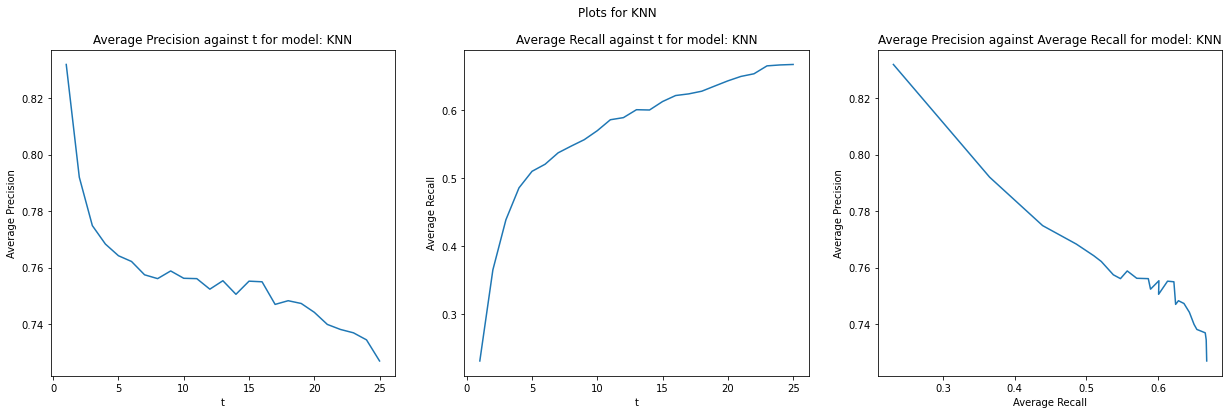

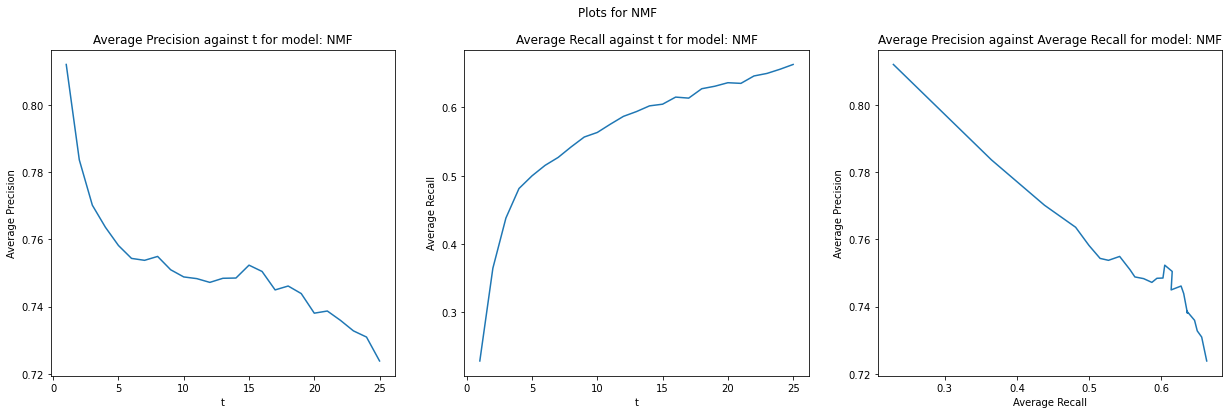

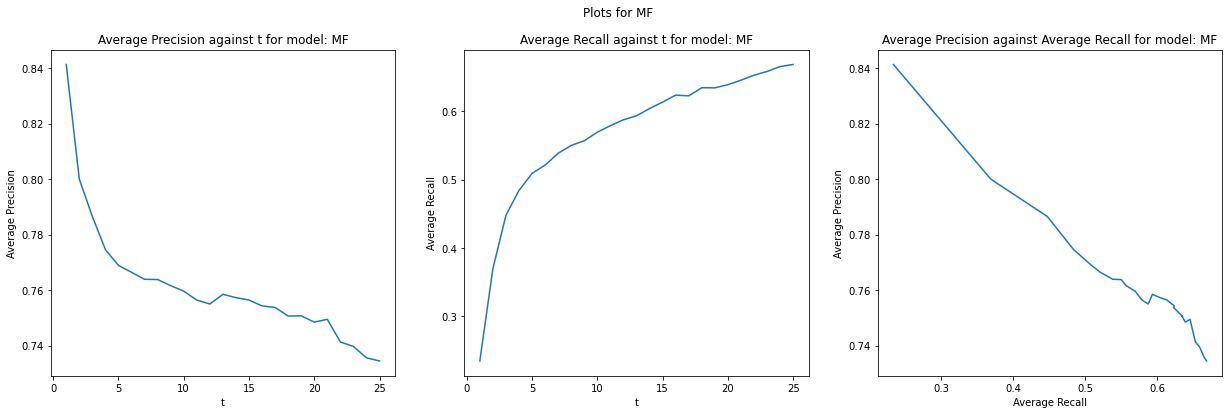

In [104]:
plot_titles_q14 = {
    0: {'x_label':'t', 'y_label':'Average Precision', 'title':'Average Precision against t'},
    1: {'x_label':'t', 'y_label':'Average Recall', 'title':'Average Recall against t'},
    2: {'x_label':'Average Recall', 'y_label':'Average Precision', 'title':'Average Precision against Average Recall'}
}
model_types = ['KNN','NMF','MF']
for model_name in model_types:
    fig, axs = plt.subplots(1, 3, figsize=(21,6))
    # precision vs t plot
    xs = [t_range_q14, t_range_q14, q14_res_dfs['avg_recall_'+model_name].values.tolist() ]
    ys = [q14_res_dfs['avg_precision_'+model_name].values.tolist(), q14_res_dfs['avg_recall_'+model_name].values.tolist(), q14_res_dfs['avg_precision_'+model_name].values.tolist()] 
    for i, (x,y)  in enumerate(zip(xs,ys)):
        axs[i].plot(x,y)
        axs[i].set(xlabel=plot_titles_q14[i]['x_label'], ylabel=plot_titles_q14[i]['y_label'])
        axs[i].set_title(plot_titles_q14[i]['title']+f' for model: {model_name}')
    plt.suptitle(f'Plots for {model_name}')
    plt.show()
        

__Precision vs t plots:__

In all precision vs t plots, we can see the non-monotonic decreasing trends. As t increase the precision mostly decrease and this shows an inverse relation between t and average precision. For KNN, there is a smooth decreasee until the middle of t=5 and 10, and then the curve becomes less smooth, during the experiment from start to end precision lowers more than 0.08. For NMF, we again see similar curve but the smoothness is preserved longer, around until t= 12-13. For MF with bias,  the precision vs t plot is the smoothest one, and the one that has highest precision range, it starts from 0.84 and drops until below 0.74. 

__Recall vs t plots:__

The recall vs t relationship is positive. As t increase recall also increases, which makes sense, the more movie we recommend the more of the liked movies by the user we can cover. The curves for all 3 models follows the same trend. 

__Avg Precision vs Avg Recall plots:__

There is an inverse relationship between precision and recall. As recall increases the precision decrease for all 3 plots. The trends for the curves same for all 3 models. MF with bias has the highest precision rate when the recall is smallest among the models. Also for all 3 plots, the curves become less smooth for the recall values above 0.5. We can also clearly see the precision-recall tradeoff from these plots since these two metrics are in inverse relationship. We need to find an optimal t point where both recall and precision is acceptable.

#### Combined Plots

I also plotted the combined plots for each type of plots, to be able to compare the models better:

##### __Average Precision against t__

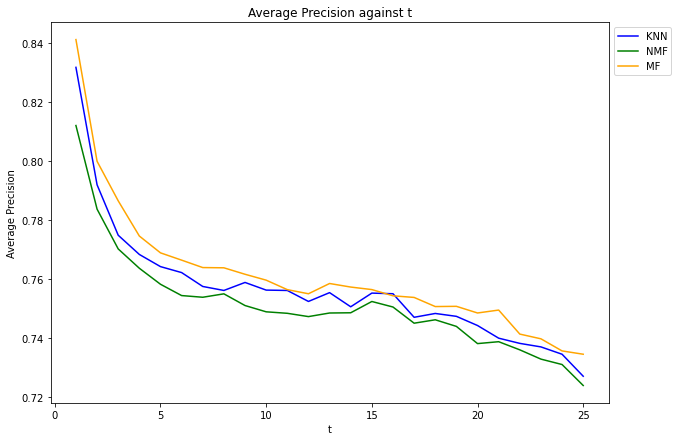

In [105]:
model_types = ['KNN','NMF','MF']
plot_evaluation_metric(x= t_range_q14, 
                       ys=[q14_res_dfs['avg_precision_KNN'].values.tolist(), q14_res_dfs['avg_precision_NMF'].values.tolist(), q14_res_dfs['avg_precision_MF'].values.tolist()],
                       x_label='t',
                       y_label='Average Precision',
                       title=f'Average Precision against t', 
                       labels=model_types)

From the above plot, we can see that MF with bias overall has the best and smoothest precision vs t plot. It starts and finish with higher precision values for different ts. If we want to have high precision generally it seems best to keep the t lower. KNN is the second best model in terms of precision and NMF is the worst one.  

##### __Average Recall against t__

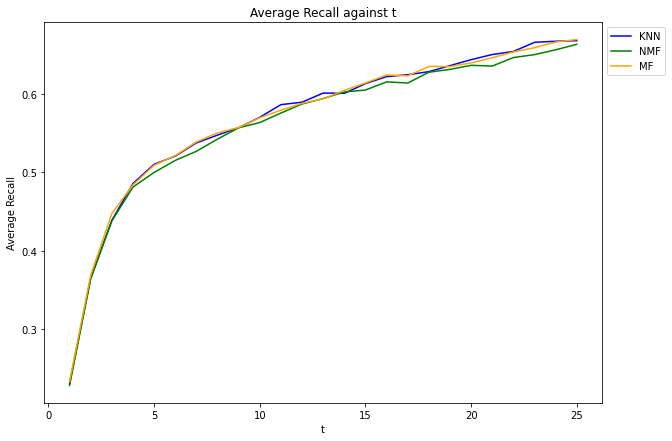

In [107]:
model_types = ['KNN','NMF','MF']
plot_evaluation_metric(x= t_range_q14, 
                       ys=[q14_res_dfs['avg_recall_KNN'].values.tolist(), q14_res_dfs['avg_recall_NMF'].values.tolist(), q14_res_dfs['avg_recall_MF'].values.tolist()],
                       x_label='t',
                       y_label='Average Recall',
                       title=f'Average Recall against t', 
                       labels=model_types)

The recall curves for each model are more similar to each other compared to precision curves. From the above plot it is very hard to tell which model is better in terms of recall because the marginal differences are very close. NMF looks slighlt worse then the other 2 models though.

Given that we saw precision and recall tradeoff in individual plots, and seeing no high difference in terms of recall in these models, the model selection can be made based on the model which has good precision. In this case, MF with bias would be a better model compared the others for the recommendation system of the given data. 

##### __Precision - Recall Curve Combined__

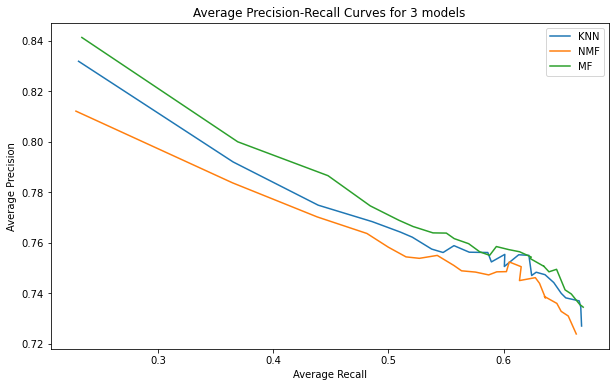

In [106]:
plot_titles_q14_comb = {'x_label':'Average Recall', 'y_label':'Average Precision', 'title':'Average Precision-Recall Curves for 3 models'}
model_types = ['KNN','NMF','MF']
fig = plt.figure(figsize=(10,6))
for model_name in model_types:
        plt.plot(q14_res_dfs['avg_recall_'+model_name].values.tolist(), q14_res_dfs['avg_precision_'+model_name].values.tolist(), label=model_name)
plt.xlabel(xlabel=plot_titles_q14_comb['x_label'])
plt.ylabel(ylabel=plot_titles_q14_comb['y_label'])
plt.title(plot_titles_q14_comb['title'])
plt.legend()
plt.show() 

All three models has inverse precision-recall relationship as described above plots. From combined recall plots, we saw that there is not much difference of the recall against different t's in the models, hence the main driver and difference we see in this plot is coming from the precision differences of the models. In precision-recall curves the closer the line to the upper right side, the better model for recommendation for this dataset is, in this case the best model for this dataset is MF with bias. Since the slope of the green line is also smaller (closer to the right upper side), we can do the precision-recall trade-off better because increasing recall would decrease the precision less than the other models. So, we can minimize the trade-off by choosing MF with bias as our best model. The second best choice seems to be KNN and the worst one is NMF.

In [ ]:
### Additional Explorations
# Understaindg Impossible Prediction Rate
counts= []
ratios = []
for i in range(50):
    train_data, test_data = train_test_split(ratings_data, test_size=0.1)
    model = get_model(model_type='KNN', k=20)
    model.fit(train_data)
    preds = model.test(test_data)

    count = 0
    for pred in preds:
        if 'reason' in pred[4].keys() and pred[4]['reason']=='User and/or item is unknown.':

            count+=1
    counts.append(count)
    ratios.append(count/len(preds))

pd.DataFrame(ratios).describe().T